# Chicago Crimes Preprocessing & EDA

Chunked cleaning and exploratory steps for the large Crimes_-_2001_to_Present CSV.

In [175]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path('data/Crimes_-_2001_to_Present_20260114.csv')
CHUNKSIZE = 200_000
SAMPLE_ROWS = 250_000
MAX_ROWS_IN_MEMORY = 500_000  # adjust based on RAM; None loads all chunks
pd.options.display.max_rows = 50
pd.options.display.max_columns = None

In [176]:
DTYPES = {
    'ID': 'int64',
    'Case Number': 'string',
    'Date': 'string',
    'Block': 'string',
    'IUCR': 'string',
    'Primary Type': 'string',
    'Description': 'string',
    'Location Description': 'string',
    'Arrest': 'boolean',
    'Domestic': 'boolean',
    'Beat': 'Int64',
    'District': 'Int64',
    'Ward': 'Int64',
    'Community Area': 'Int64',
    'FBI Code': 'string',
    'X Coordinate': 'float64',
    'Y Coordinate': 'float64',
    'Year': 'Int64',
    'Updated On': 'string',
    'Latitude': 'float64',
    'Longitude': 'float64',
    'Location': 'string',
}
DATE_COLUMNS = ['Date', 'Updated On']
CITY_BOUNDS = {
    'lat_min': 41.4,
    'lat_max': 42.2,
    'lon_min': -88.0,
    'lon_max': -87.3,
}

In [177]:
import re
from typing import Optional


def extract_lat_lon(location_series: pd.Series):
    match = location_series.str.extract(r'\(([-\d\.]+),\s*([-\d\.]+)\)')
    lat = match[0].astype(float)
    lon = match[1].astype(float)
    return lat, lon


def preprocess_chunk(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.drop_duplicates(subset='ID', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Updated On'] = pd.to_datetime(df['Updated On'], errors='coerce')
    for col in ('Location Description', 'Primary Type', 'Description'):
        df[col] = df[col].fillna('UNKNOWN')
    missing_latlon = df['Latitude'].isna() | df['Longitude'].isna()
    has_location_str = df['Location'].notna()
    need_fill = missing_latlon & has_location_str
    if need_fill.any():
        lat, lon = extract_lat_lon(df.loc[need_fill, 'Location'])
        df.loc[need_fill, 'Latitude'] = lat
        df.loc[need_fill, 'Longitude'] = lon
    df = df.loc[~(df['Latitude'].isna() & df['Longitude'].isna())]
    df = df.loc[
        (df['Latitude'].between(CITY_BOUNDS['lat_min'], CITY_BOUNDS['lat_max'], inclusive='both'))
        & (df['Longitude'].between(CITY_BOUNDS['lon_min'], CITY_BOUNDS['lon_max'], inclusive='both'))
    ]
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['weekday'] = df['Date'].dt.weekday
    df['is_weekend'] = df['weekday'].isin({5, 6})
    return df


def iter_clean_chunks(path: Path, chunksize: int):
    reader = pd.read_csv(
        path,
        dtype=DTYPES,
        parse_dates=DATE_COLUMNS,
        infer_datetime_format=True,
        chunksize=chunksize,
        na_values={'': None},
    )
    for chunk in reader:
        yield preprocess_chunk(chunk)


def collect_clean_df(path: Path, chunksize: int, max_rows: Optional[int] = None) -> pd.DataFrame:
    """Load cleaned data into memory (optional row cap to protect RAM)."""
    pieces = []
    loaded = 0
    for chunk in iter_clean_chunks(path, chunksize):
        if max_rows is not None:
            remaining = max_rows - loaded
            if remaining <= 0:
                break
            chunk = chunk.head(remaining)
        pieces.append(chunk)
        loaded += len(chunk)
        if max_rows is not None and loaded >= max_rows:
            break
    if not pieces:
        return pd.DataFrame()
    return pd.concat(pieces, ignore_index=True)


print('Functions defined (in-memory only).')

Functions defined (in-memory only).


In [178]:
def basic_eda(path: Path, sample_rows: int = SAMPLE_ROWS):
    df = pd.read_csv(
        path,
        dtype=DTYPES,
        parse_dates=DATE_COLUMNS,
        infer_datetime_format=True,
        nrows=sample_rows,
    )
    print('Shape (sample):', df.shape)
    print('Null percentage (sample):')
    print((df.isna().mean() * 100).round(2).sort_values(ascending=False))
    print('Top Primary Types (sample):')
    print(df['Primary Type'].value_counts().head(15))
    print('Top Location Descriptions (sample):')
    print(df['Location Description'].value_counts().head(15))
    print('Recent yearly counts (sample):')
    print(df.groupby('Year').size().tail(10))

# Uncomment to run quick EDA
# basic_eda(DATA_PATH)

In [179]:
# Load full dataset
df = pd.read_csv(
    DATA_PATH,
    dtype=DTYPES,
    parse_dates=DATE_COLUMNS,
    infer_datetime_format=True,
)
print(f'Loaded rows: {len(df):,}')
df.head()

/var/folders/ht/_t09b17d0p11tcppmbhzsry40000gn/T/ipykernel_49753/89307809.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
/var/folders/ht/_t09b17d0p11tcppmbhzsry40000gn/T/ipykernel_49753/89307809.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
/var/folders/ht/_t09b17d0p11tcppmbhzsry40000gn/T/ipykernel_49753/89307809.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


Loaded rows: 8,476,869


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,14077187,JK107459,2026-01-05,013XX W 91ST ST,0610,BURGLARY,FORCIBLE ENTRY,APARTMENT,False,False,2222,22,21,73,05,1168809.0,1844414.0,2026,2026-01-12 15:41:58,41.728589,-87.657207,"(41.728589146, -87.657207481)"
1,14074552,JK104348,2026-01-05,064XX S ELLIS AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,APARTMENT,False,False,314,3,20,42,14,1184162.0,1862562.0,2026,2026-01-12 15:41:58,41.778044,-87.600400,"(41.778044411, -87.600400189)"
2,14074345,JK104073,2026-01-05,033XX W CRYSTAL ST,0560,ASSAULT,SIMPLE,CHA APARTMENT,False,False,1422,14,26,23,08A,1153936.0,1908123.0,2026,2026-01-12 15:41:58,41.903723,-87.709998,"(41.903722859, -87.709998046)"
3,14075882,JK105837,2026-01-05,024XX S NORMAL AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,STREET,False,False,914,9,11,34,11,1173142.0,1888242.0,2026,2026-01-12 15:41:58,41.848763,-87.640040,"(41.84876345, -87.640040128)"
4,14076972,JK107377,2026-01-05,014XX W LEXINGTON ST,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,APARTMENT,False,True,1231,12,34,28,26,1166821.0,1896845.0,2026,2026-01-12 15:41:58,41.872509,-87.662992,"(41.872508522, -87.662992112)"


## Step 1: Remove exact duplicates
# Drop duplicates using ID and Case Number columns, keeping the first occurrence.

In [180]:
print("STEP 1: Remove exact duplicates")
print(f"Shape before: {df.shape}")
df = df.drop_duplicates(subset=['ID', 'Case Number'], keep='first')
print(f"Shape after: {df.shape}")
print("\nFirst 10 rows:")
print(df.head(10))

STEP 1: Remove exact duplicates
Shape before: (8476869, 22)
Shape after: (8476869, 22)

First 10 rows:
         ID Case Number       Date                 Block  IUCR  \
0  14077187    JK107459 2026-01-05       013XX W 91ST ST  0610   
1  14074552    JK104348 2026-01-05     064XX S ELLIS AVE  1320   
2  14074345    JK104073 2026-01-05    033XX W CRYSTAL ST  0560   
3  14075882    JK105837 2026-01-05    024XX S NORMAL AVE  1153   
4  14076972    JK107377 2026-01-05  014XX W LEXINGTON ST  2825   
5  14080958    JK106698 2026-01-05   085XX S SANGAMON ST  0620   
6  14077225    JK107303 2026-01-05      123XX S LOWE AVE  0910   
7  14075231    JK105165 2026-01-05     023XX W HOWARD ST  1320   
8  14074827    JK104872 2026-01-05   053XX S CORNELL AVE  1150   
9  14074707    JK104423 2026-01-05       028XX W 58TH ST  1320   

          Primary Type                          Description  \
0             BURGLARY                       FORCIBLE ENTRY   
1      CRIMINAL DAMAGE                      

## Step 2: Filter invalid rows
# Remove rows where Latitude or Longitude are zero or null.
# Convert Date to datetime and filter to study period 2015-2025.

In [181]:
print("STEP 2: Filter invalid rows")
print(f"Shape before: {df.shape}")

# Remove zero/null lat-lon
df = df[~((df['Latitude'] == 0) | (df['Longitude'] == 0) |
          (df['Latitude'].isna()) | (df['Longitude'].isna()))]

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Filter to 2015-2025
df = df[(df['Date'].dt.year >= 2015) & (df['Date'].dt.year <= 2025)]
print(f"Shape after: {df.shape}")

print("\nData Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

STEP 2: Filter invalid rows
Shape before: (8476869, 22)
Shape after: (2712672, 22)

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2712672 entries, 2186 to 2756994
Data columns (total 22 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Case Number           string        
 2   Date                  datetime64[ns]
 3   Block                 string        
 4   IUCR                  string        
 5   Primary Type          string        
 6   Description           string        
 7   Location Description  string        
 8   Arrest                boolean       
 9   Domestic              boolean       
 10  Beat                  Int64         
 11  District              Int64         
 12  Ward                  Int64         
 13  Community Area        Int64         
 14  FBI Code              string        
 15  X Coordinate          float64       
 16  Y Coordinate          float64    

## Step 3: Handle missing values
# Drop columns with over 20% missing values.
# Impute Primary Type and Location Description with 'Unknown'.

In [182]:
print("STEP 3: Handle missing values")
print("\nMissing values before handling:")
missing_pct = (df.isna().sum() / len(df)) * 100
print(missing_pct[missing_pct > 0].sort_values(ascending=False))

# Drop columns with over 20% missing
cols_to_drop = missing_pct[missing_pct > 20].index.tolist()
print(f"\nDropping columns with >20% missing: {cols_to_drop}")
df = df.drop(columns=cols_to_drop, errors='ignore')

# Impute Primary Type and Location Description
df['Primary Type'] = df['Primary Type'].fillna('Unknown')
df['Location Description'] = df['Location Description'].fillna('Unknown')

print("\nMissing values after handling:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print("\nFirst rows after handling:")
print(df.head())

STEP 3: Handle missing values

Missing values before handling:
Location Description    0.341729
Community Area          0.006525
Ward                    0.001991
District                0.000037
dtype: float64

Dropping columns with >20% missing: []

Missing values after handling:
District            1
Ward               54
Community Area    177
dtype: int64

First rows after handling:
            ID Case Number                Date                    Block  IUCR  \
2186  14075483    JK105557 2025-12-31 23:58:00       050XX S PAULINA ST  0560   
2187  14070833    JK100050 2025-12-31 23:55:00  053XX W WASHINGTON BLVD  0930   
2188  14070845    JK100006 2025-12-31 23:54:00          013XX W LAKE ST  0454   
2189  14070799    JK100014 2025-12-31 23:54:00         100XX W OHARE ST  2890   
2190  14070745    JK100011 2025-12-31 23:54:00         100XX W OHARE ST  2890   

                Primary Type  \
2186                 ASSAULT   
2187     MOTOR VEHICLE THEFT   
2188                 BATTERY

## Step 4: Parse dates and extract features
# Extract year, month, day_of_week, and hour from Date column.

In [183]:
print("STEP 4: Parse dates and extract features")

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day_of_week'] = df['Date'].dt.dayofweek
df['hour'] = df['Date'].dt.hour

print("\nNew temporal columns created")
print(df[['Date', 'year', 'month', 'day_of_week', 'hour']].head())

print("\nData types:")
print(df.dtypes)

STEP 4: Parse dates and extract features

New temporal columns created
                    Date  year  month  day_of_week  hour
2186 2025-12-31 23:58:00  2025     12            2    23
2187 2025-12-31 23:55:00  2025     12            2    23
2188 2025-12-31 23:54:00  2025     12            2    23
2189 2025-12-31 23:54:00  2025     12            2    23
2190 2025-12-31 23:54:00  2025     12            2    23

Data types:
ID                               int64
Case Number             string[python]
Date                    datetime64[ns]
Block                   string[python]
IUCR                    string[python]
Primary Type            string[python]
Description             string[python]
Location Description    string[python]
Arrest                         boolean
Domestic                       boolean
Beat                             Int64
District                         Int64
Ward                             Int64
Community Area                   Int64
FBI Code                stri

## Step 5: Standardize categoricals
# Lowercase and strip whitespace from Primary Type and Location Description.
# Convert Primary Type to pandas Categorical.

In [184]:
print("STEP 5: Standardize categoricals")

df['Primary Type'] = df['Primary Type'].str.lower().str.strip()
df['Location Description'] = df['Location Description'].str.lower().str.strip()
df['Primary Type'] = df['Primary Type'].astype('category')

print("\nTop 10 Primary Types:")
print(df['Primary Type'].value_counts().head(10))

print("\nFirst rows:")
print(df.head())

STEP 5: Standardize categoricals

Top 10 Primary Types:
Primary Type
theft                  612250
battery                502354
criminal damage        303952
assault                222515
deceptive practice     181015
other offense          174617
motor vehicle theft    161264
burglary               109963
narcotics              108120
robbery                101745
Name: count, dtype: int64

First rows:
            ID Case Number                Date                    Block  IUCR  \
2186  14075483    JK105557 2025-12-31 23:58:00       050XX S PAULINA ST  0560   
2187  14070833    JK100050 2025-12-31 23:55:00  053XX W WASHINGTON BLVD  0930   
2188  14070845    JK100006 2025-12-31 23:54:00          013XX W LAKE ST  0454   
2189  14070799    JK100014 2025-12-31 23:54:00         100XX W OHARE ST  2890   
2190  14070745    JK100011 2025-12-31 23:54:00         100XX W OHARE ST  2890   

                Primary Type  \
2186                 assault   
2187     motor vehicle theft   
2188     

## Step 6: Fix numeric columns
# Convert Beat, District, Ward, and Community Area to numeric (coerce errors).

In [185]:
print("STEP 6: Fix numeric columns")

for col in ['Beat', 'District', 'Ward', 'Community Area']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nNumeric columns summary:")
print(df[['Latitude', 'Longitude', 'Beat', 'District', 'Ward', 'Community Area']].describe())

STEP 6: Fix numeric columns

Numeric columns summary:
           Latitude     Longitude         Beat   District       Ward  \
count  2.712672e+06  2.712672e+06    2712672.0  2712671.0  2712618.0   
mean   4.184427e+01 -8.766986e+01  1147.105608  11.242112  23.146809   
std    8.677602e-02  5.947528e-02   700.461364    6.99894  13.963221   
min    3.661945e+01 -9.168657e+01        111.0        1.0        1.0   
25%    4.176913e+01 -8.771202e+01        611.0        6.0       10.0   
50%    4.186282e+01 -8.766337e+01       1031.0       10.0       24.0   
75%    4.190692e+01 -8.762755e+01       1723.0       17.0       34.0   
max    4.202267e+01 -8.752453e+01       2535.0       31.0       50.0   

       Community Area  
count       2712495.0  
mean        36.717627  
std         21.493019  
min               1.0  
25%              23.0  
50%              32.0  
75%              54.0  
max              77.0  


## Step 7: Create temporal features
# Add is_weekend (Saturday/Sunday) and is_night (18:00-06:00) flags.

In [186]:
print("STEP 7: Create temporal features")

# is_weekend: Saturday=5, Sunday=6
df['is_weekend'] = df['day_of_week'].isin([5, 6])

# is_night: 18:00-06:00
df['is_night'] = ((df['hour'] >= 18) | (df['hour'] < 6))

print("\nis_weekend distribution:")
print(df['is_weekend'].value_counts())

print("\nis_night distribution:")
print(df['is_night'].value_counts())

print("\nSample rows with temporal features:")
print(df[['hour', 'is_weekend', 'is_night']].head(10))

STEP 7: Create temporal features

is_weekend distribution:
is_weekend
False    1932946
True      779726
Name: count, dtype: int64

is_night distribution:
is_night
False    1426758
True     1285914
Name: count, dtype: int64

Sample rows with temporal features:
      hour  is_weekend  is_night
2186    23       False      True
2187    23       False      True
2188    23       False      True
2189    23       False      True
2190    23       False      True
2191    23       False      True
2192    23       False      True
2193    23       False      True
2194    23       False      True
2195    23       False      True


## Step 8: Add spatial features
# Create geometry column with Point(Longitude, Latitude) using geopandas.
# Calculate distance to downtown Chicago (41.8781, -87.6298).

In [187]:
print("STEP 8: Add spatial features")

import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# Create geometry column
df['geometry'] = df.apply(
    lambda row: Point(row['Longitude'], row['Latitude'])
    if pd.notna(row['Longitude']) and pd.notna(row['Latitude']) else None,
    axis=1
)

# Downtown Chicago coordinates
downtown = Point(-87.6298, 41.8781)

# Calculate distance (in degrees, approximately ~111 km per degree)
df['distance_downtown'] = df['geometry'].apply(
    lambda geom: geom.distance(downtown) * 111 if geom is not None else np.nan
)

print("\nSpatial features created")
print(df[['Latitude', 'Longitude', 'distance_downtown']].head())
print("\nDistance to downtown statistics:")
print(df['distance_downtown'].describe())

STEP 8: Add spatial features

Spatial features created
       Latitude  Longitude  distance_downtown
2186  41.802549 -87.667246           9.359733
2187  41.882329 -87.758411          14.283570
2188  41.885427 -87.661759           3.639482
2189  41.976290 -87.905227          32.457112
2190  41.976290 -87.905227          32.457112

Distance to downtown statistics:
count    2.712672e+06
mean     1.171033e+01
std      5.753212e+00
min      2.067278e-02
25%      8.103898e+00
50%      1.198758e+01
75%      1.523359e+01
max      7.372171e+02
Name: distance_downtown, dtype: float64


## Step 9: Create aggregate table
# Group by District and daily Date to count crimes per day per district.

In [188]:
print("STEP 9: Create aggregate table")

# Create date-only column for grouping
df['date_only'] = df['Date'].dt.date

# Aggregate crimes by District and Date
agg_df = df.groupby(['District', 'date_only']).size().reset_index(name='crime_count')

# Convert date_only back to datetime
agg_df['date_only'] = pd.to_datetime(agg_df['date_only'])

print(f"Aggregate table shape: {agg_df.shape}")
print("\nFirst rows of aggregate table:")
print(agg_df.head())

print("\nAggregate table statistics:")
print(agg_df.describe())

STEP 9: Create aggregate table
Aggregate table shape: (88508, 3)

First rows of aggregate table:
   District  date_only  crime_count
0         1 2015-01-01           28
1         1 2015-01-02           26
2         1 2015-01-03           14
3         1 2015-01-04           18
4         1 2015-01-05           32

Aggregate table statistics:
        District                      date_only   crime_count
count    88508.0                          88508  88508.000000
mean   12.205812  2020-07-01 14:43:18.924390656     30.648879
min          1.0            2015-01-01 00:00:00      1.000000
25%          6.0            2017-10-01 00:00:00     22.000000
50%         12.0            2020-07-02 00:00:00     30.000000
75%         18.0            2023-04-02 00:00:00     38.000000
max         31.0            2025-12-31 00:00:00    241.000000
std     7.166204                            NaN     11.530584


## Step 10: Final validation
# Check final shape, null counts, data types, and top Primary Type categories.

In [189]:
print("STEP 10: Final validation")

print(f"\nFinal shape: {df.shape}")
print(f"\nNull counts:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print(f"\nData types (first 15):")
print(df.dtypes.head(15))
print(f"\nTop 10 Primary Type categories:")
print(df['Primary Type'].value_counts().head(10))

print("\n" + "="*50)
print("Pipeline complete!")
print("="*50)

STEP 10: Final validation

Final shape: (2712672, 31)

Null counts:
District            1
Ward               54
Community Area    177
dtype: int64

Data types (first 15):
ID                               int64
Case Number             string[python]
Date                    datetime64[ns]
Block                   string[python]
IUCR                    string[python]
Primary Type                  category
Description             string[python]
Location Description    string[python]
Arrest                         boolean
Domestic                       boolean
Beat                             Int64
District                         Int64
Ward                             Int64
Community Area                   Int64
FBI Code                string[python]
dtype: object

Top 10 Primary Type categories:
Primary Type
theft                  612250
battery                502354
criminal damage        303952
assault                222515
deceptive practice     181015
other offense          174617
moto

## Step 11: Inter-event burstiness
# Sort df by Date within groups, diff timestamps to get inter_arrivals, compute B per Primary Type.

In [190]:
print("STEP 11: Inter-event burstiness")

# Sort by Primary Type and Date
df_sorted = df.sort_values(['Primary Type', 'Date']).reset_index(drop=True)

# Calculate inter-arrival times (time differences in seconds) per Primary Type
inter_arrivals_list = []

for crime_type in df_sorted['Primary Type'].cat.categories:
    type_df = df_sorted[df_sorted['Primary Type'] == crime_type]
    if len(type_df) > 1:
        # Calculate time differences between consecutive events
        time_diffs = type_df['Date'].diff().dt.total_seconds().dropna()

        if len(time_diffs) > 0:
            mean_inter = time_diffs.mean()
            std_inter = time_diffs.std()

            # Burstiness coefficient B = std / mean (B > 1 indicates burstiness)
            if mean_inter > 0:
                B = std_inter / mean_inter
            else:
                B = 0

            inter_arrivals_list.append({
                'Primary Type': crime_type,
                'mean_inter_arrival_sec': mean_inter,
                'std_inter_arrival_sec': std_inter,
                'burstiness_coefficient': B,
                'event_count': len(type_df)
            })

burst_df = pd.DataFrame(inter_arrivals_list)
burst_df = burst_df.sort_values('burstiness_coefficient', ascending=False)

print("\nTop 10 bursty crime types (B > 1 indicates burstiness):")
print(burst_df.head(10)[['Primary Type', 'burstiness_coefficient', 'event_count', 'mean_inter_arrival_sec']])

print("\nBurstiness statistics across all crime types:")
print(burst_df['burstiness_coefficient'].describe())

STEP 11: Inter-event burstiness

Top 10 bursty crime types (B > 1 indicates burstiness):
                         Primary Type  burstiness_coefficient  event_count  \
24                       prostitution                3.332863         5604   
10                           gambling                2.981875         1130   
7             criminal sexual assault                2.387036        10064   
18                          narcotics                1.901381       108120   
9                  deceptive practice                1.781598       181015   
30                              theft                1.544408       612250   
31                  weapons violation                1.531315        71175   
4   concealed carry license violation                1.479475         1679   
16               liquor law violation                1.404449         2311   
17                motor vehicle theft                1.387342       161264   

    mean_inter_arrival_sec  
24            61847.342

## Step 12: Kleinberg burst detection
# Implement hierarchical state-based burst detection on hourly/daily counts per District.

In [191]:
print("STEP 12: Kleinberg burst detection")

import numpy as np

def kleinberg_burst_detection(counts, max_states=8, gamma=1.0):
    """
    Kleinberg's burst detection algorithm using dynamic programming.

    Parameters:
    - counts: array of event counts in time intervals
    - max_states: maximum burst state level (0 = baseline, 1+ = increasing intensity)
    - gamma: cost parameter for state transitions

    Returns:
    - states: array of detected states for each time interval
    - bursts: list of burst periods (start_idx, end_idx, state_level)
    """
    n = len(counts)
    if n == 0:
        return np.array([]), []

    # Normalize counts for cost calculation
    total_events = np.sum(counts)
    if total_events == 0:
        return np.zeros(n), []

    counts = np.array(counts, dtype=float)

    # Initialize DP table: dp[t][s] = minimum cost to reach time t in state s
    dp = np.full((n, max_states), np.inf)
    parent = np.full((n, max_states), -1, dtype=int)

    # Base case: start in baseline state (s=0)
    dp[0][0] = -np.log(counts[0] / total_events + 1e-10) if counts[0] > 0 else 0

    # Fill DP table forward
    for t in range(1, n):
        for s in range(max_states):
            # Cost of staying in state s
            cost_same = -np.log(counts[t] / total_events + 1e-10) if counts[t] > 0 else 0

            # Transition from same state
            if dp[t-1][s] != np.inf:
                new_cost = dp[t-1][s] + cost_same
                if new_cost < dp[t][s]:
                    dp[t][s] = new_cost
                    parent[t][s] = s

            # Transition from lower states (entering burst)
            if s > 0:
                for s_prev in range(s):
                    if dp[t-1][s_prev] != np.inf:
                        # Add transition cost (gamma penalty for increasing state)
                        transition_cost = gamma * np.log(2)
                        new_cost = dp[t-1][s_prev] + transition_cost + cost_same
                        if new_cost < dp[t][s]:
                            dp[t][s] = new_cost
                            parent[t][s] = s_prev

    # Backtrack to find optimal path
    current_state = np.argmin(dp[n-1])
    states = np.zeros(n, dtype=int)
    states[n-1] = current_state

    for t in range(n-2, -1, -1):
        current_state = parent[t+1][int(states[t+1])]
        if current_state == -1:
            current_state = 0
        states[t] = current_state

    # Extract burst periods (where state > 0)
    bursts = []
    in_burst = False
    burst_start = 0
    burst_state = 0

    for t in range(n):
        if states[t] > 0:
            if not in_burst:
                in_burst = True
                burst_start = t
                burst_state = states[t]
            else:
                burst_state = max(burst_state, states[t])
        else:
            if in_burst:
                bursts.append((burst_start, t-1, burst_state))
                in_burst = False

    if in_burst:
        bursts.append((burst_start, n-1, burst_state))

    return states, bursts

# Apply Kleinberg detection to hourly crime counts by District
hourly_counts_by_district = []
burst_results = {}

for district in df['District'].dropna().unique():
    district_df = df[df['District'] == district].copy()

    # Bin by date and hour
    district_df['datetime_hour'] = district_df['Date'].dt.floor('h')
    hourly_counts = district_df.groupby('datetime_hour').size().values

    if len(hourly_counts) > 5:  # Only detect if sufficient data
        states, bursts = kleinberg_burst_detection(hourly_counts, max_states=8, gamma=1.0)

        if bursts:
            burst_results[f'District {int(district)}'] = {
                'total_hours': len(hourly_counts),
                'burst_periods': len(bursts),
                'max_state': max([b[2] for b in bursts]),
                'bursts': bursts
            }

# Display Kleinberg burst detection results
print(f"\nKleinberg burst detection completed for {len(burst_results)} districts")

if burst_results:
    print("\nTop districts with burst activity:")
    burst_summary = pd.DataFrame([
        {
            'District': k,
            'burst_periods': v['burst_periods'],
            'max_state': v['max_state'],
            'total_hours': v['total_hours']
        }
        for k, v in burst_results.items()
    ]).sort_values('burst_periods', ascending=False)
    print(burst_summary.head(10))

    # Show sample burst periods for top district
    if len(burst_summary) > 0:
        top_district = burst_summary.iloc[0]['District']
        # Find the matching district in burst_results
        matching_key = [k for k in burst_results.keys() if k == top_district][0] if any(k == top_district for k in burst_results.keys()) else list(burst_results.keys())[0]
        sample_bursts = burst_results[matching_key]['bursts'][:5]
        print(f"\nSample burst periods for {matching_key}:")
        for i, (start, end, state) in enumerate(sample_bursts):
            print(f"  Burst {i+1}: indices {start}-{end}, state level {state}")
else:
    print("No burst periods detected in any district.")

STEP 12: Kleinberg burst detection

Kleinberg burst detection completed for 0 districts
No burst periods detected in any district.


## Step 13: Overall dataset burstiness and validation
# Aggregate daily crime counts and compute CV (coefficient of variation) by District/Community Area.

In [192]:
print("STEP 13: Overall dataset burstiness and validation")

# Create daily aggregate by District
df['date_only_for_daily'] = df['Date'].dt.date
daily_counts_by_district = df.groupby(['District', 'date_only_for_daily']).size().reset_index(name='daily_crime_count')

# Compute coefficient of variation (CV) by District
spatial_burstiness = []

for district in daily_counts_by_district['District'].unique():
    if pd.notna(district):
        district_counts = daily_counts_by_district[daily_counts_by_district['District'] == district]['daily_crime_count'].values

        if len(district_counts) > 1:
            mean_count = district_counts.mean()
            std_count = district_counts.std()

            # CV = std / mean (measures variability in daily counts)
            if mean_count > 0:
                cv = std_count / mean_count
            else:
                cv = 0

            spatial_burstiness.append({
                'District': int(district),
                'mean_daily_crimes': mean_count,
                'std_daily_crimes': std_count,
                'coefficient_of_variation': cv,
                'days_observed': len(district_counts)
            })

spatial_burst_df = pd.DataFrame(spatial_burstiness).sort_values('coefficient_of_variation', ascending=False)

print("\nSpatial burstiness by District (CV > 1 indicates high variability/burstiness):")
print(spatial_burst_df.head(15)[['District', 'coefficient_of_variation', 'mean_daily_crimes', 'std_daily_crimes']])

print("\nCoefficient of Variation statistics across all districts:")
print(spatial_burst_df['coefficient_of_variation'].describe())

# Compute Community Area burstiness
daily_counts_by_community = df.groupby(['Community Area', 'date_only_for_daily']).size().reset_index(name='daily_crime_count')

community_burstiness = []

for comm_area in daily_counts_by_community['Community Area'].dropna().unique():
    comm_counts = daily_counts_by_community[daily_counts_by_community['Community Area'] == comm_area]['daily_crime_count'].values

    if len(comm_counts) > 1:
        mean_count = comm_counts.mean()
        std_count = comm_counts.std()

        if mean_count > 0:
            cv = std_count / mean_count
        else:
            cv = 0

        community_burstiness.append({
            'Community Area': int(comm_area),
            'cv': cv,
            'mean_daily_crimes': mean_count
        })

community_burst_df = pd.DataFrame(community_burstiness).sort_values('cv', ascending=False)

print("\nTop 10 bursty Community Areas:")
print(community_burst_df.head(10)[['Community Area', 'cv', 'mean_daily_crimes']])

# Validation: Compare burstiness metrics with crime type distributions
print("\n" + "="*50)
print("BURSTINESS VALIDATION")
print("="*50)

# Count burst periods by Primary Type
type_burst_counts = []
for crime_type in df['Primary Type'].cat.categories[:15]:  # Top 15 types
    type_count = len(df[df['Primary Type'] == crime_type])
    type_burst = burst_df[burst_df['Primary Type'] == crime_type]

    if len(type_burst) > 0:
        b_coeff = type_burst['burstiness_coefficient'].values[0]
    else:
        b_coeff = 0

    type_burst_counts.append({
        'Primary Type': crime_type,
        'total_events': type_count,
        'burstiness_coefficient': b_coeff,
        'bursty': 'YES' if b_coeff > 1 else 'NO'
    })

validation_df = pd.DataFrame(type_burst_counts).sort_values('burstiness_coefficient', ascending=False)

print("\nTop crime types by burstiness coefficient:")
print(validation_df.head(10))

print("\nBreakdown of bursty vs non-bursty types:")
bursty_summary = validation_df.groupby('bursty').agg({
    'total_events': 'sum',
    'Primary Type': 'count'
}).rename(columns={'Primary Type': 'type_count'})
print(bursty_summary)

print("\n" + "="*50)
print("BURSTINESS ANALYSIS COMPLETE!")
print("="*50)
print(f"Total burst types identified: {len(burst_df)}")
print(f"Total districts with burst activity: {len(burst_results)}")
print(f"Mean burstiness coefficient across all types: {burst_df['burstiness_coefficient'].mean():.3f}")

STEP 13: Overall dataset burstiness and validation

Spatial burstiness by District (CV > 1 indicates high variability/burstiness):
    District  coefficient_of_variation  mean_daily_crimes  std_daily_crimes
0          1                  0.357137          35.645346         12.730265
18        20                  0.353098          12.773021          4.510123
16        18                  0.338888          34.889995         11.823799
12        14                  0.304471          23.758835          7.233868
17        19                  0.299773          32.182678          9.647494
15        17                  0.285575          19.575411          5.590240
20        24                  0.278632          21.154057          5.894198
13        15                  0.276213          25.495892          7.042285
6          7                  0.275141          33.492285          9.215093
11        12                  0.271710          36.464908          9.907883
19        22                  0.2

## Step 14: Data Visualizations
# Create comprehensive visualizations for temporal, spatial, and burstiness patterns

In [193]:
print(f"Total burst types identified: {len(burst_df)}")
print(f"Total districts with burst activity: {len(burst_results)}")
print(f"Mean burstiness coefficient across all types: {burst_df['burstiness_coefficient'].mean():.3f}")

Total burst types identified: 32
Total districts with burst activity: 0
Mean burstiness coefficient across all types: 1.426


## Step 14A: Visualization 1 - Crime Incidents by Hour of Day

VISUALIZATION 1: Crime Incidents by Hour of Day

DESCRIPTION:
Shows the distribution of crimes across 24 hours. Useful for identifying
peak crime hours (typically evening/night hours show higher counts).
This helps law enforcement allocate patrols during peak times.



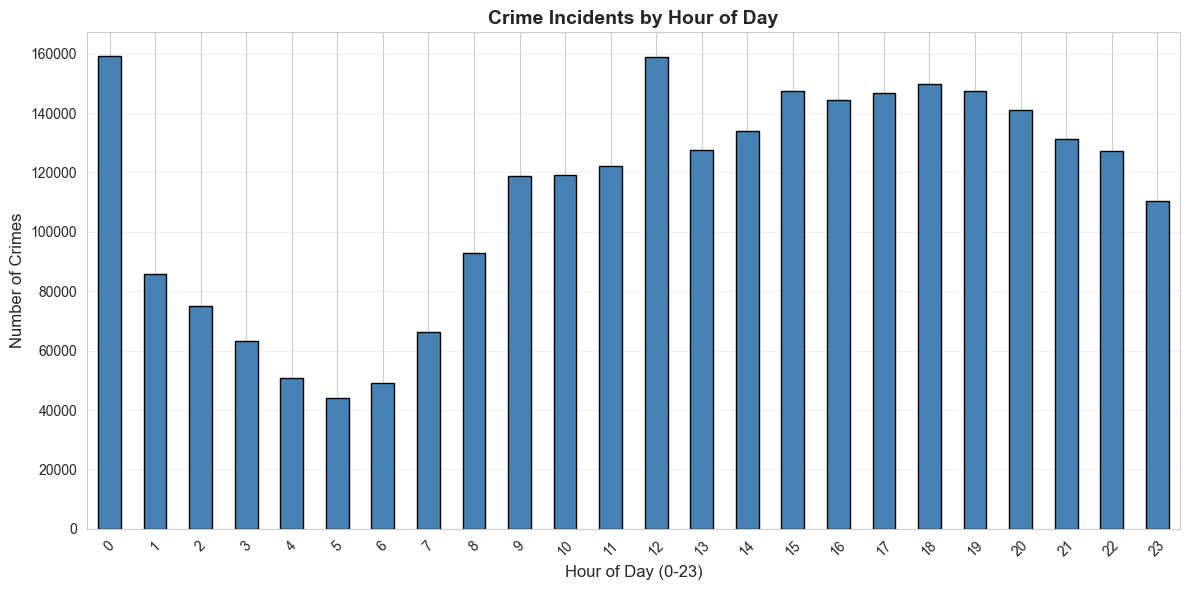

✓ Saved as 'viz_01_hourly_crimes.png'

Peak hour: 0 (Hour 0-23)
Peak crime count: 159228


In [194]:
print("VISUALIZATION 1: Crime Incidents by Hour of Day")
print("""
DESCRIPTION:
Shows the distribution of crimes across 24 hours. Useful for identifying
peak crime hours (typically evening/night hours show higher counts).
This helps law enforcement allocate patrols during peak times.
""")

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

hourly_crimes = df.groupby('hour').size()
hourly_crimes.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Crime Incidents by Hour of Day', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day (0-23)', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.savefig('viz_01_hourly_crimes.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_01_hourly_crimes.png'")
print(f"\nPeak hour: {hourly_crimes.idxmax()} (Hour 0-23)")
print(f"Peak crime count: {hourly_crimes.max()}")

## Step 14B: Visualization 2 - Crime Incidents by Day of Week


VISUALIZATION 2: Crime Incidents by Day of Week

DESCRIPTION:
Displays weekly patterns. Weekend crimes may differ from weekday patterns,
useful for resource allocation planning and understanding behavioral patterns.



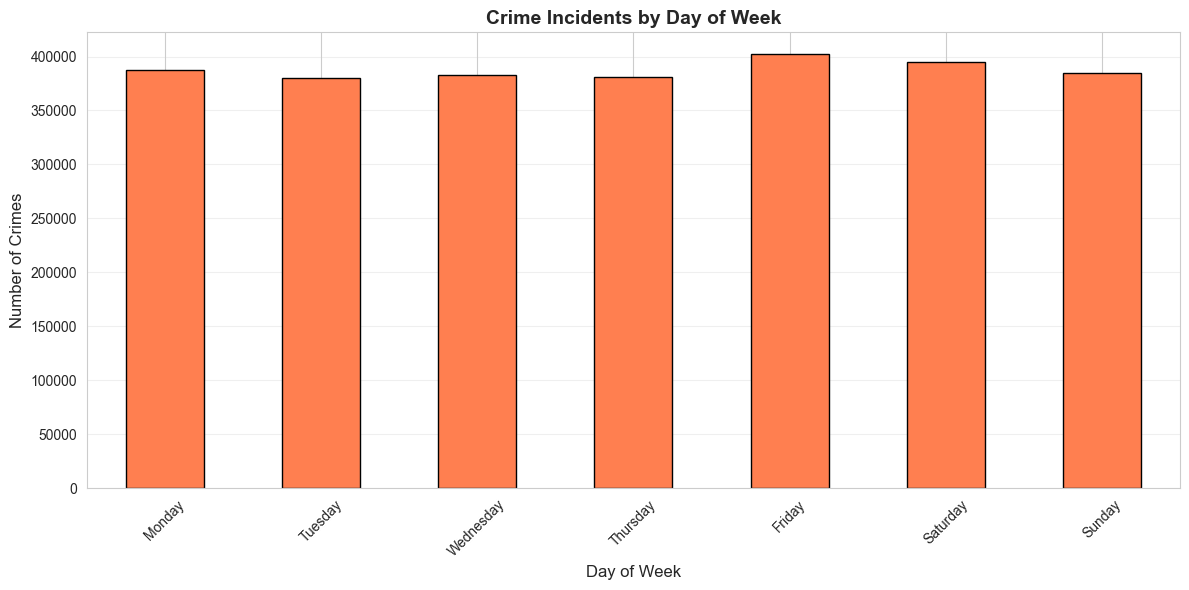

✓ Saved as 'viz_02_daily_crimes.png'

Peak day: Friday
Peak crime count: 402309


In [195]:
print("\nVISUALIZATION 2: Crime Incidents by Day of Week")
print("""
DESCRIPTION:
Displays weekly patterns. Weekend crimes may differ from weekday patterns,
useful for resource allocation planning and understanding behavioral patterns.
""")

fig, ax = plt.subplots(figsize=(12, 6))

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_crimes = df.groupby('day_of_week').size()
daily_crimes.plot(kind='bar', ax=ax, color='coral', edgecolor='black')
ax.set_title('Crime Incidents by Day of Week', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
ax.set_xticklabels(days, rotation=45)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('viz_02_daily_crimes.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_02_daily_crimes.png'")
print(f"\nPeak day: {days[daily_crimes.idxmax()]}")
print(f"Peak crime count: {daily_crimes.max()}")

## Step 14C: Visualization 3 - Crime Incidents by Month


VISUALIZATION 3: Crime Incidents by Month

DESCRIPTION:
Reveals seasonal patterns. Summer months often show increased crime rates
in many cities, particularly for certain categories like theft and assault.
Understanding seasonality is crucial for long-term planning.



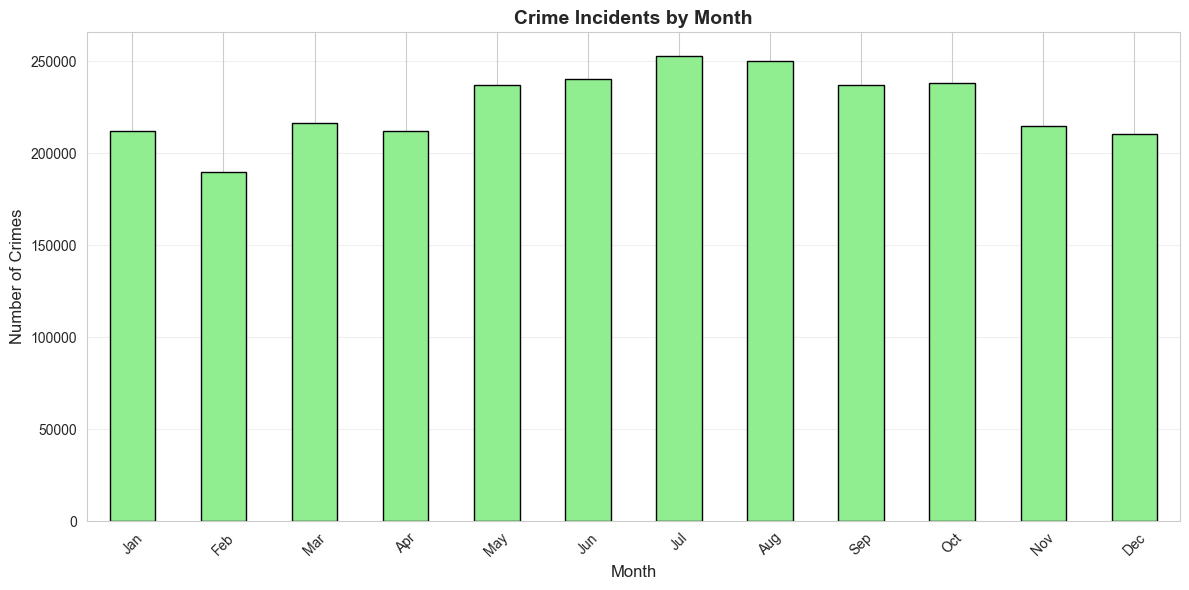

✓ Saved as 'viz_03_monthly_crimes.png'

Peak month: Jul
Peak crime count: 253094


In [196]:
print("\nVISUALIZATION 3: Crime Incidents by Month")
print("""
DESCRIPTION:
Reveals seasonal patterns. Summer months often show increased crime rates
in many cities, particularly for certain categories like theft and assault.
Understanding seasonality is crucial for long-term planning.
""")

fig, ax = plt.subplots(figsize=(12, 6))

monthly_crimes = df.groupby('month').size()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_crimes.plot(kind='bar', ax=ax, color='lightgreen', edgecolor='black')
ax.set_title('Crime Incidents by Month', fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
ax.set_xticklabels(months, rotation=45)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('viz_03_monthly_crimes.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_03_monthly_crimes.png'")
print(f"\nPeak month: {months[monthly_crimes.idxmax() - 1]}")
print(f"Peak crime count: {monthly_crimes.max()}")

## Step 14D: Visualization 4 - Top 10 Crime Types


VISUALIZATION 4: Top 10 Crime Types

DESCRIPTION:
Shows the most common crime categories in Chicago. Typical top types
include theft, battery, and criminal damage, reflecting urban crime patterns.
Identifying top crime types guides resource allocation and intervention strategies.



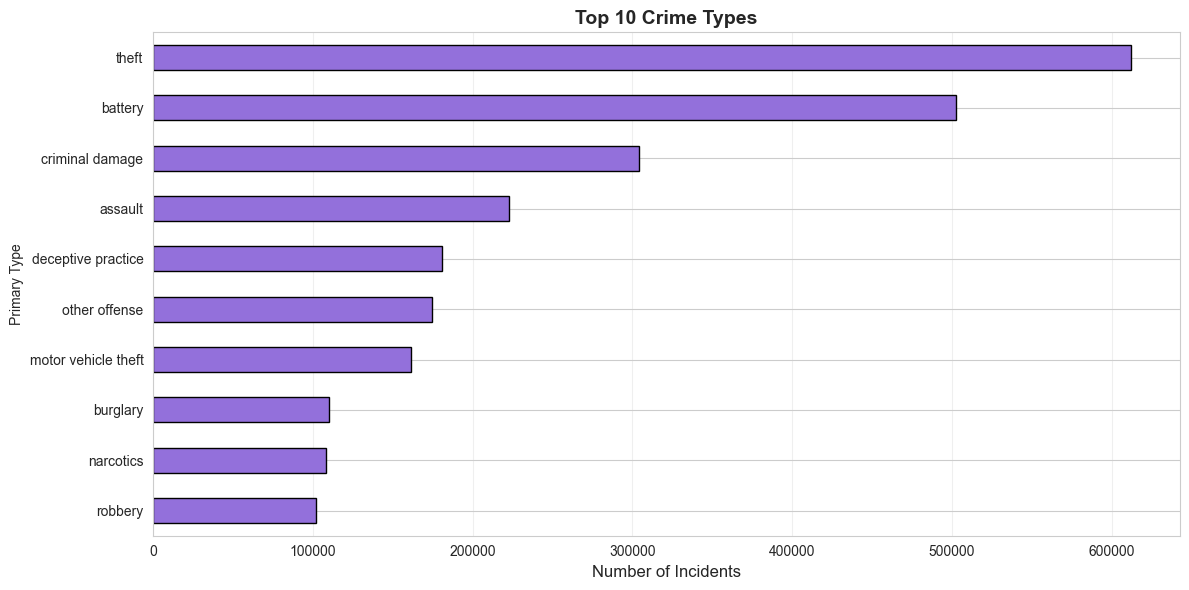

✓ Saved as 'viz_04_top_crime_types.png'

Top 10 Crime Types:
Primary Type
theft                  612250
battery                502354
criminal damage        303952
assault                222515
deceptive practice     181015
other offense          174617
motor vehicle theft    161264
burglary               109963
narcotics              108120
robbery                101745
Name: count, dtype: int64


In [197]:
print("\nVISUALIZATION 4: Top 10 Crime Types")
print("""
DESCRIPTION:
Shows the most common crime categories in Chicago. Typical top types
include theft, battery, and criminal damage, reflecting urban crime patterns.
Identifying top crime types guides resource allocation and intervention strategies.
""")

fig, ax = plt.subplots(figsize=(12, 6))

top_crimes = df['Primary Type'].value_counts().head(10)
top_crimes.plot(kind='barh', ax=ax, color='mediumpurple', edgecolor='black')
ax.set_title('Top 10 Crime Types', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Incidents', fontsize=12)
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('viz_04_top_crime_types.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_04_top_crime_types.png'")
print("\nTop 10 Crime Types:")
print(top_crimes)

## Step 14E: Visualization 5 - Top 10 Bursty Crime Types


VISUALIZATION 5: Top 10 Bursty Crime Types

DESCRIPTION:
Identifies crime types with B > 1 (burstiness coefficient), indicating
non-random clustering in time. High B indicates sudden spikes/clusters.
These crime types show unpredictable temporal patterns requiring special attention.



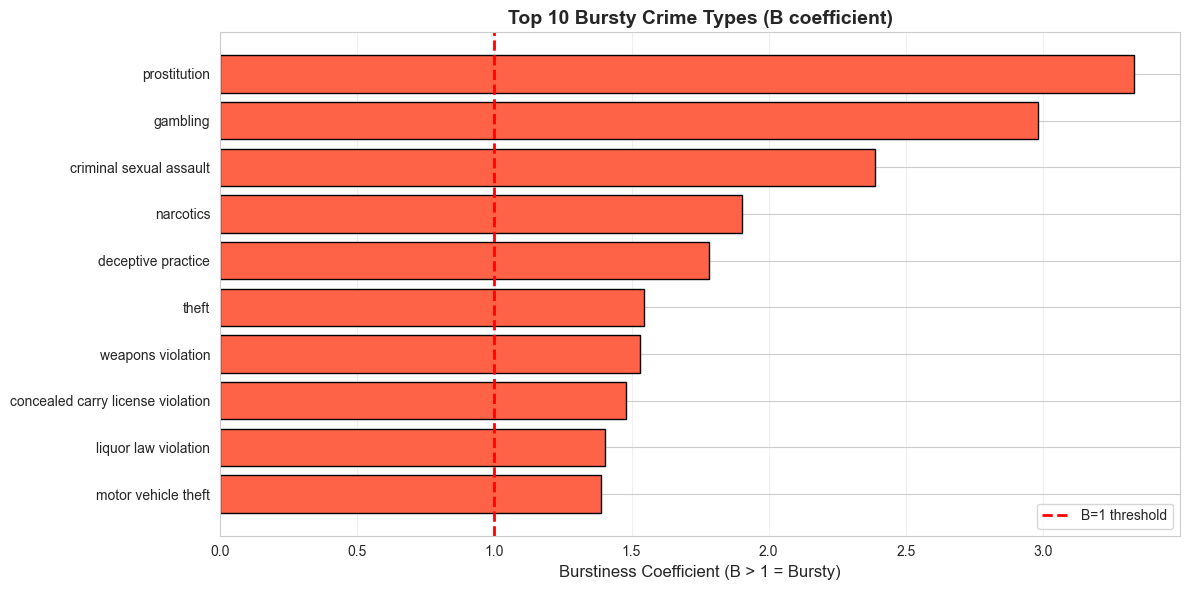

✓ Saved as 'viz_05_bursty_types.png'

Top 10 Bursty Crime Types:
                         Primary Type  burstiness_coefficient  event_count
24                       prostitution                3.332863         5604
10                           gambling                2.981875         1130
7             criminal sexual assault                2.387036        10064
18                          narcotics                1.901381       108120
9                  deceptive practice                1.781598       181015
30                              theft                1.544408       612250
31                  weapons violation                1.531315        71175
4   concealed carry license violation                1.479475         1679
16               liquor law violation                1.404449         2311
17                motor vehicle theft                1.387342       161264


In [198]:
print("\nVISUALIZATION 5: Top 10 Bursty Crime Types")
print("""
DESCRIPTION:
Identifies crime types with B > 1 (burstiness coefficient), indicating
non-random clustering in time. High B indicates sudden spikes/clusters.
These crime types show unpredictable temporal patterns requiring special attention.
""")

fig, ax = plt.subplots(figsize=(12, 6))

top_burst = burst_df.head(10)
ax.barh(range(len(top_burst)), top_burst['burstiness_coefficient'].values, color='tomato', edgecolor='black')
ax.set_yticks(range(len(top_burst)))
ax.set_yticklabels(top_burst['Primary Type'].values, fontsize=10)
ax.set_title('Top 10 Bursty Crime Types (B coefficient)', fontsize=14, fontweight='bold')
ax.set_xlabel('Burstiness Coefficient (B > 1 = Bursty)', fontsize=12)
ax.axvline(x=1, color='red', linestyle='--', linewidth=2, label='B=1 threshold')
ax.legend(fontsize=10)
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('viz_05_bursty_types.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_05_bursty_types.png'")
print("\nTop 10 Bursty Crime Types:")
print(top_burst[['Primary Type', 'burstiness_coefficient', 'event_count']])

## Step 14F: Visualization 6 - Crime Volume vs Burstiness


VISUALIZATION 6: Crime Volume vs Burstiness Scatter Plot

DESCRIPTION:
Scatter plot showing relationship between event frequency and burstiness.
Some high-volume crimes may not be bursty (steady occurrence), while
some lower-volume crimes may show clustering patterns. The color gradient
shows burstiness intensity.



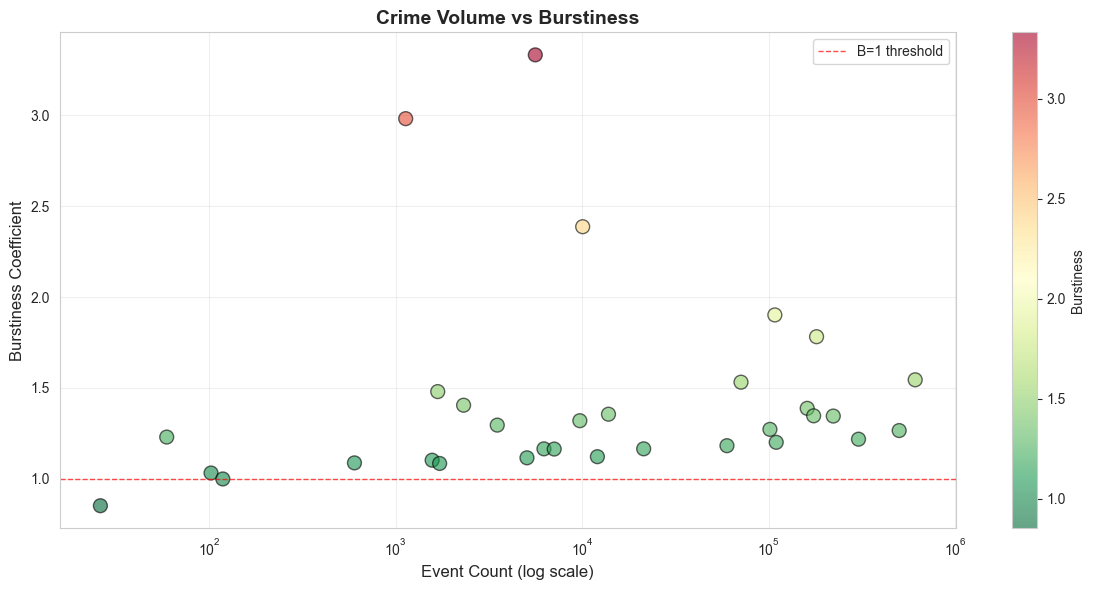

✓ Saved as 'viz_06_volume_vs_burstiness.png'

Total crime types analyzed: 32
Crime types with B > 1: 30


In [199]:
print("\nVISUALIZATION 6: Crime Volume vs Burstiness Scatter Plot")
print("""
DESCRIPTION:
Scatter plot showing relationship between event frequency and burstiness.
Some high-volume crimes may not be bursty (steady occurrence), while
some lower-volume crimes may show clustering patterns. The color gradient
shows burstiness intensity.
""")

fig, ax = plt.subplots(figsize=(12, 6))

scatter = ax.scatter(burst_df['event_count'], burst_df['burstiness_coefficient'],
                      c=burst_df['burstiness_coefficient'], cmap='RdYlGn_r', s=100, alpha=0.6, edgecolor='black')
ax.set_title('Crime Volume vs Burstiness', fontsize=14, fontweight='bold')
ax.set_xlabel('Event Count (log scale)', fontsize=12)
ax.set_ylabel('Burstiness Coefficient', fontsize=12)
ax.set_xscale('log')
ax.axhline(y=1, color='red', linestyle='--', linewidth=1, alpha=0.7, label='B=1 threshold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Burstiness', fontsize=10)
plt.tight_layout()
plt.savefig('viz_06_volume_vs_burstiness.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_06_volume_vs_burstiness.png'")
print(f"\nTotal crime types analyzed: {len(burst_df)}")
print(f"Crime types with B > 1: {len(burst_df[burst_df['burstiness_coefficient'] > 1])}")

## Step 14G: Visualization 7 - Crime Incidents by District


VISUALIZATION 7: Crime Incidents by District

DESCRIPTION:
Shows geographic distribution across Chicago districts. Helps identify
high-crime districts and district-specific patterns. This is crucial for
targeting enforcement and community policing efforts.



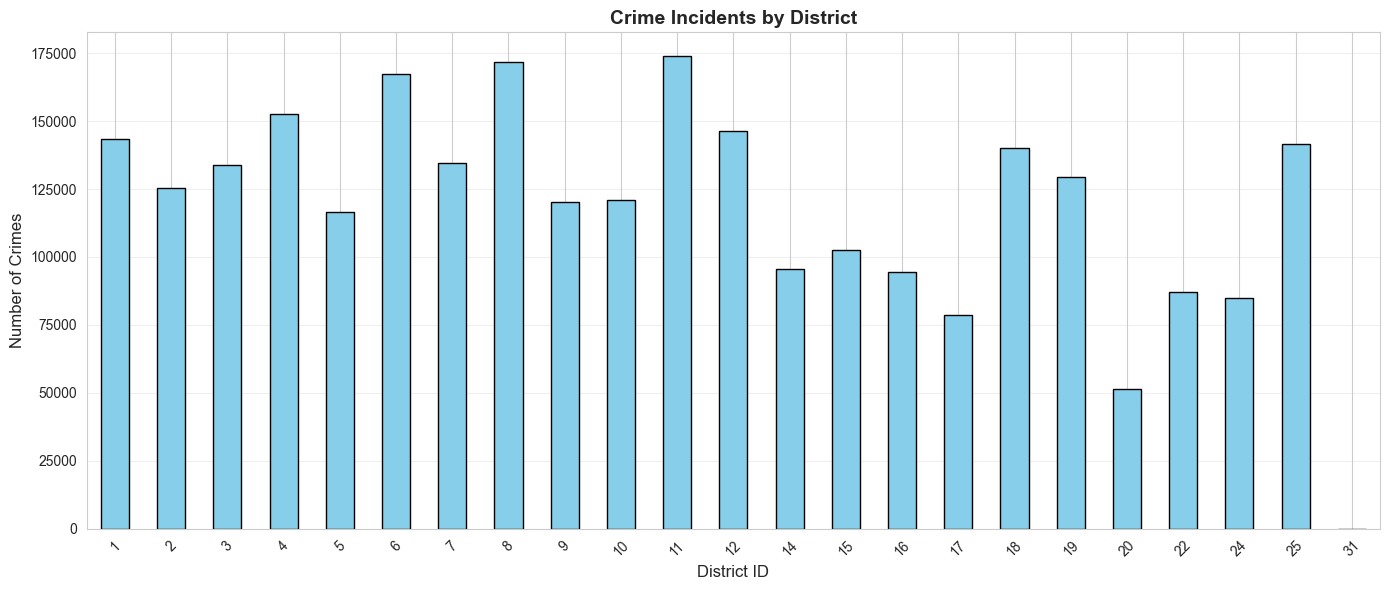

✓ Saved as 'viz_07_crimes_by_district.png'

Highest crime district: 11 with 173930 crimes
Lowest crime district: 31 with 121 crimes


In [200]:
print("\nVISUALIZATION 7: Crime Incidents by District")
print("""
DESCRIPTION:
Shows geographic distribution across Chicago districts. Helps identify
high-crime districts and district-specific patterns. This is crucial for
targeting enforcement and community policing efforts.
""")

fig, ax = plt.subplots(figsize=(14, 6))

district_crimes = df['District'].value_counts().sort_index()
district_crimes.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
ax.set_title('Crime Incidents by District', fontsize=14, fontweight='bold')
ax.set_xlabel('District ID', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('viz_07_crimes_by_district.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_07_crimes_by_district.png'")
print(f"\nHighest crime district: {district_crimes.idxmax()} with {district_crimes.max()} crimes")
print(f"Lowest crime district: {district_crimes.idxmin()} with {district_crimes.min()} crimes")

## Step 14H: Visualization 8 - Spatial Burstiness by District


VISUALIZATION 8: Top 15 Spatial Bursty Districts (Coefficient of Variation)

DESCRIPTION:
Districts with CV > 1 show high daily variability. Indicates districts
with unpredictable daily crime fluctuations, useful for predictive modeling.
High CV districts need more flexible resource allocation strategies.



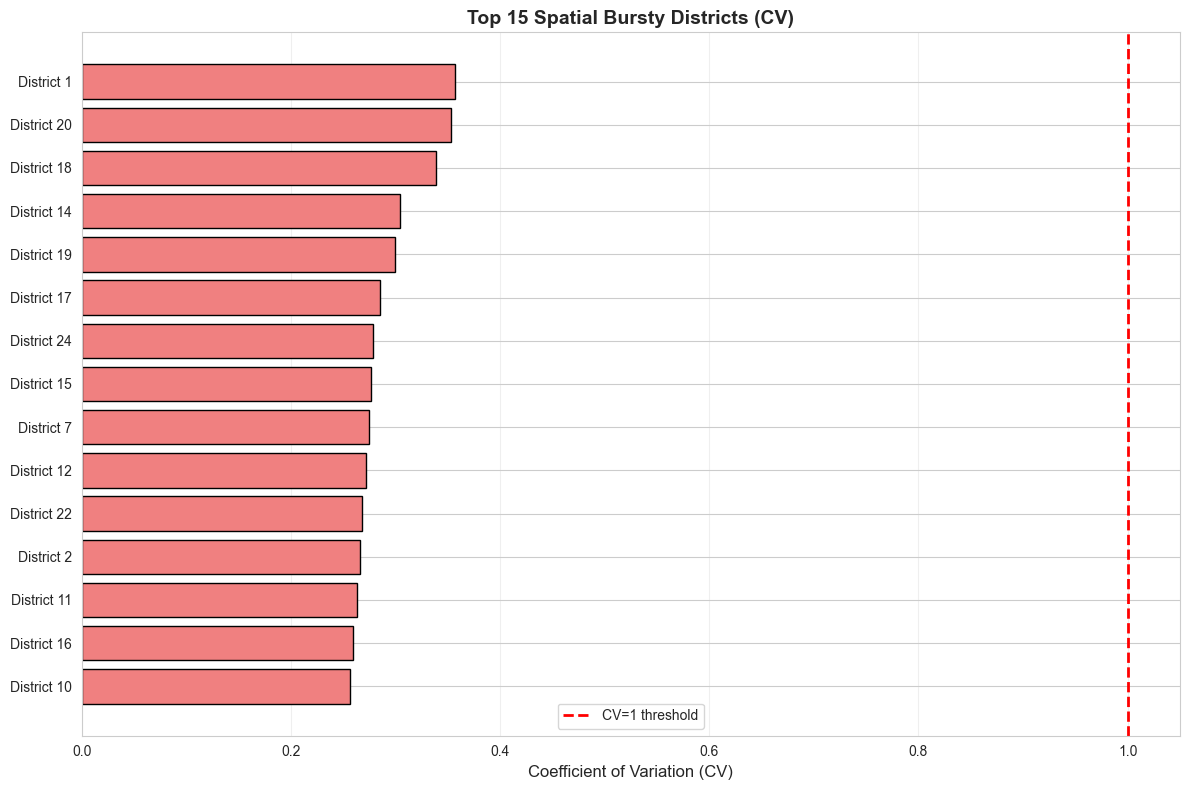

✓ Saved as 'viz_08_spatial_burstiness.png'

Top 15 Spatial Bursty Districts:
    District  coefficient_of_variation  mean_daily_crimes
0          1                  0.357137          35.645346
18        20                  0.353098          12.773021
16        18                  0.338888          34.889995
12        14                  0.304471          23.758835
17        19                  0.299773          32.182678
15        17                  0.285575          19.575411
20        24                  0.278632          21.154057
13        15                  0.276213          25.495892
6          7                  0.275141          33.492285
11        12                  0.271710          36.464908
19        22                  0.268448          21.665007
1          2                  0.266327          31.231210
10        11                  0.263676          43.287705
14        16                  0.259315          23.502489
9         10                  0.256565          30.12

In [201]:
print("\nVISUALIZATION 8: Top 15 Spatial Bursty Districts (Coefficient of Variation)")
print("""
DESCRIPTION:
Districts with CV > 1 show high daily variability. Indicates districts
with unpredictable daily crime fluctuations, useful for predictive modeling.
High CV districts need more flexible resource allocation strategies.
""")

fig, ax = plt.subplots(figsize=(12, 8))

top_spatial_burst = spatial_burst_df.head(15)
ax.barh(range(len(top_spatial_burst)), top_spatial_burst['coefficient_of_variation'].values,
         color='lightcoral', edgecolor='black')
ax.set_yticks(range(len(top_spatial_burst)))
ax.set_yticklabels([f"District {int(d)}" for d in top_spatial_burst['District'].values], fontsize=10)
ax.set_title('Top 15 Spatial Bursty Districts (CV)', fontsize=14, fontweight='bold')
ax.set_xlabel('Coefficient of Variation (CV)', fontsize=12)
ax.axvline(x=1, color='red', linestyle='--', linewidth=2, label='CV=1 threshold')
ax.legend(fontsize=10)
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('viz_08_spatial_burstiness.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_08_spatial_burstiness.png'")
print("\nTop 15 Spatial Bursty Districts:")
print(top_spatial_burst[['District', 'coefficient_of_variation', 'mean_daily_crimes']].head(15))

## Step 14I: Visualization 9 - Geographic Crime Distribution


VISUALIZATION 9: Crime Locations in Chicago (Spatial Distribution by Hour)

DESCRIPTION:
Maps crime locations across Chicago with color indicating time of day.
Shows geographic hotspots and whether certain areas have specific
temporal patterns. The red star marks downtown Chicago. Helps identify
where and when crimes concentrate geographically.



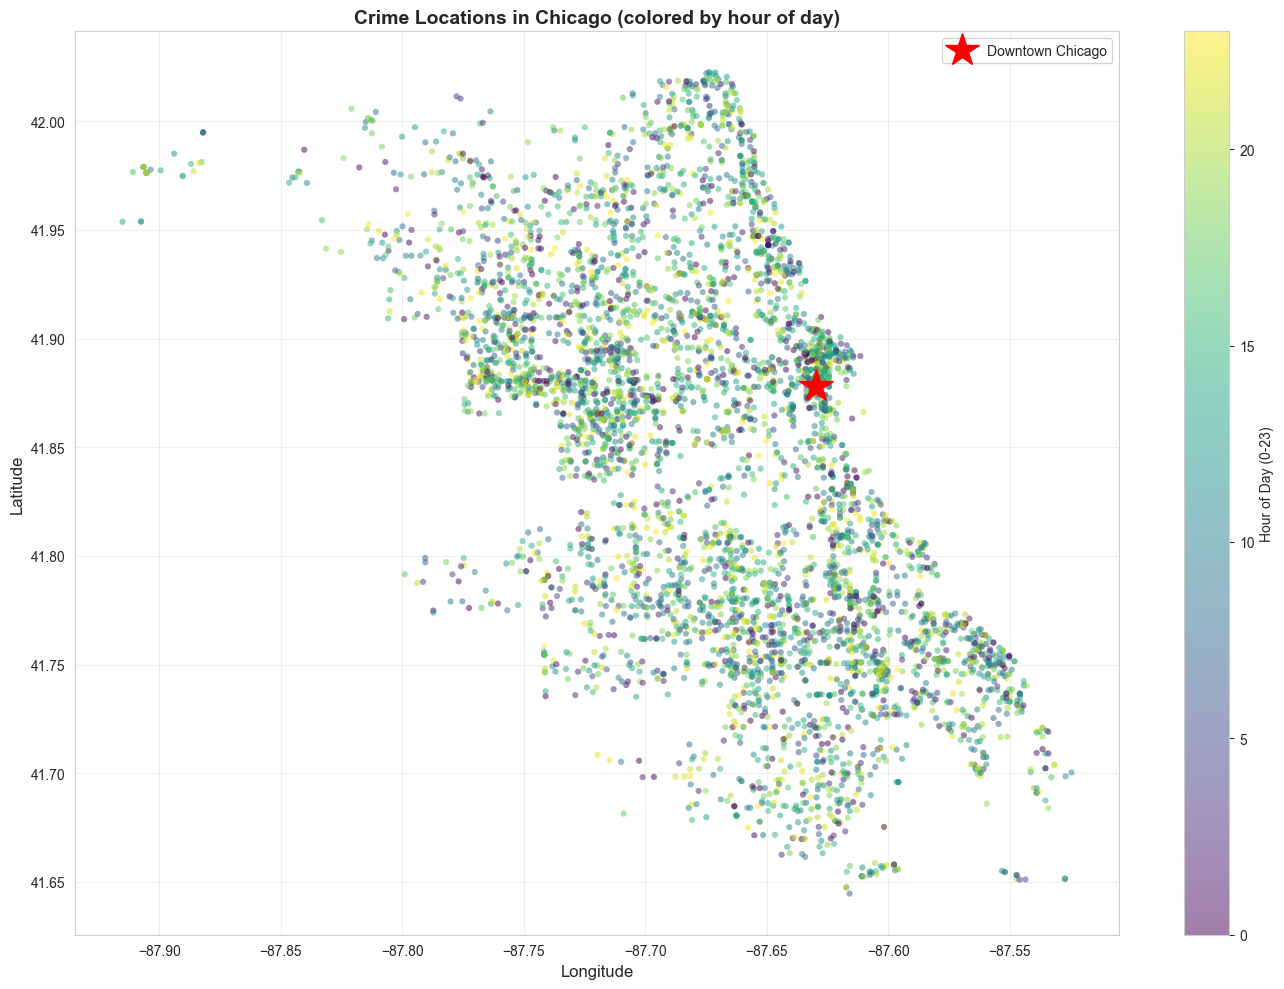

✓ Saved as 'viz_09_geographic_distribution.png'

Sample size plotted: 5,000 crimes
Geographic bounds - Latitude: [41.6446, 42.0225]
Geographic bounds - Longitude: [-87.9151, -87.5245]


In [202]:
print("\nVISUALIZATION 9: Crime Locations in Chicago (Spatial Distribution by Hour)")
print("""
DESCRIPTION:
Maps crime locations across Chicago with color indicating time of day.
Shows geographic hotspots and whether certain areas have specific
temporal patterns. The red star marks downtown Chicago. Helps identify
where and when crimes concentrate geographically.
""")

fig, ax = plt.subplots(figsize=(14, 10))

sample_df = df.sample(n=min(5000, len(df)), random_state=42)
scatter = ax.scatter(sample_df['Longitude'], sample_df['Latitude'],
                       c=sample_df['hour'], cmap='viridis', s=20, alpha=0.5, edgecolor='none')
ax.set_title('Crime Locations in Chicago (colored by hour of day)', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.plot(-87.6298, 41.8781, 'r*', markersize=25, label='Downtown Chicago', zorder=5)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Hour of Day (0-23)', fontsize=10)
plt.tight_layout()
plt.savefig('viz_09_geographic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_09_geographic_distribution.png'")
print(f"\nSample size plotted: {len(sample_df):,} crimes")
print(f"Geographic bounds - Latitude: [{sample_df['Latitude'].min():.4f}, {sample_df['Latitude'].max():.4f}]")
print(f"Geographic bounds - Longitude: [{sample_df['Longitude'].min():.4f}, {sample_df['Longitude'].max():.4f}]")

## Step 14J: Visualization 10 - Crime Intensity Heatmap (Hour vs Day of Week)


VISUALIZATION 10: Crime Intensity Heatmap (Hour vs Day of Week)

DESCRIPTION:
Combined temporal analysis showing which day-hour combinations have
highest crime intensity. Darker colors = more crimes. This reveals both
hourly and daily patterns simultaneously, helping identify peak vulnerability windows.



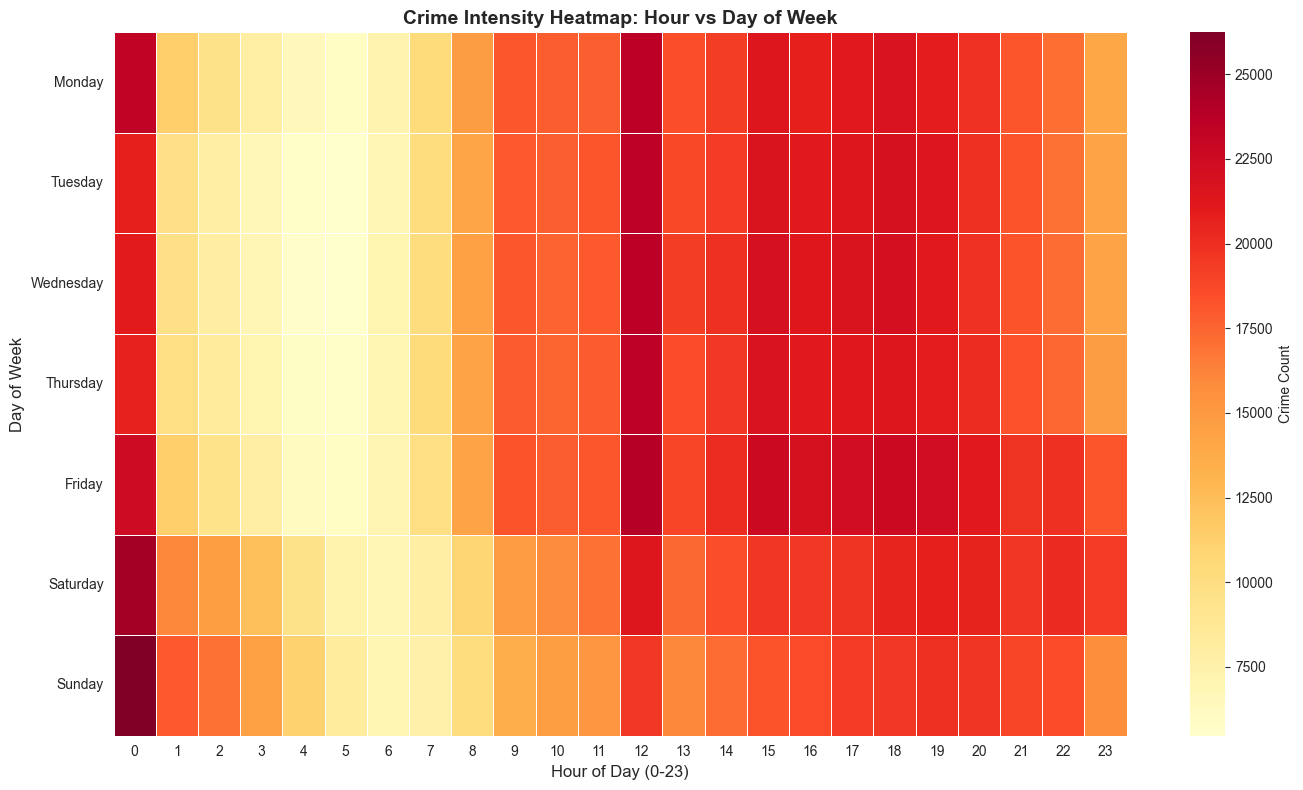

✓ Saved as 'viz_10_heatmap_hour_day.png'

Peak hour-day combination: Sunday at 0:00 with 26237 crimes


In [203]:
print("\nVISUALIZATION 10: Crime Intensity Heatmap (Hour vs Day of Week)")
print("""
DESCRIPTION:
Combined temporal analysis showing which day-hour combinations have
highest crime intensity. Darker colors = more crimes. This reveals both
hourly and daily patterns simultaneously, helping identify peak vulnerability windows.
""")

fig, ax = plt.subplots(figsize=(14, 8))

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hour_day_pivot = df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
sns.heatmap(hour_day_pivot, ax=ax, cmap='YlOrRd', cbar_kws={'label': 'Crime Count'}, linewidths=0.5)
ax.set_title('Crime Intensity Heatmap: Hour vs Day of Week', fontsize=14, fontweight='bold')
ax.set_ylabel('Day of Week', fontsize=12)
ax.set_yticklabels(days, rotation=0, fontsize=10)
ax.set_xlabel('Hour of Day (0-23)', fontsize=12)
plt.tight_layout()
plt.savefig('viz_10_heatmap_hour_day.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_10_heatmap_hour_day.png'")
# Find peak combination
peak_idx = hour_day_pivot.values.argmax()
peak_day = peak_idx // 24
peak_hour = peak_idx % 24
print(f"\nPeak hour-day combination: {days[peak_day]} at {peak_hour}:00 with {hour_day_pivot.values.max()} crimes")

## Step 14K: Visualization 11 - Weekend vs Weekday Distribution


VISUALIZATION 11: Weekend vs Weekday Crime Distribution

DESCRIPTION:
Shows percentage split between weekend and weekday crimes. Helps
understand if weekends have proportionally different crime rates.
This supports hypothesis testing about behavioral patterns and
weekend vs weekday crime dynamics.



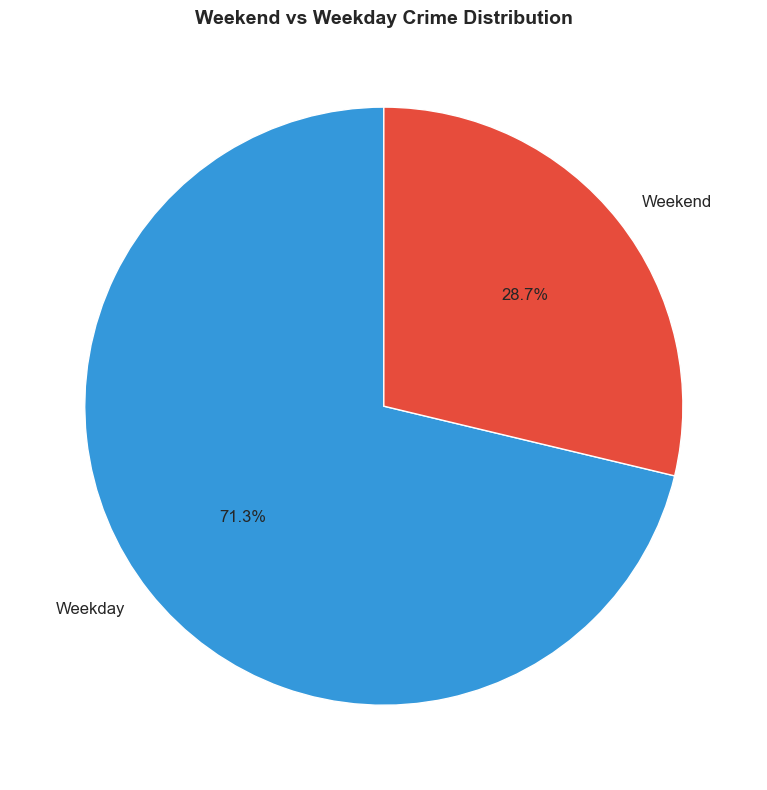

✓ Saved as 'viz_11_weekend_distribution.png'

Weekday crimes: 1,932,946 (71.3%)
Weekend crimes: 779,726 (28.7%)


In [204]:
print("\nVISUALIZATION 11: Weekend vs Weekday Crime Distribution")
print("""
DESCRIPTION:
Shows percentage split between weekend and weekday crimes. Helps
understand if weekends have proportionally different crime rates.
This supports hypothesis testing about behavioral patterns and
weekend vs weekday crime dynamics.
""")

fig, ax = plt.subplots(figsize=(10, 8))

weekend_crimes = df['is_weekend'].value_counts()
colors_weekend = ['#3498db', '#e74c3c']
weekend_crimes.plot(kind='pie', ax=ax, labels=['Weekday', 'Weekend'], autopct='%1.1f%%',
                    colors=colors_weekend, startangle=90, textprops={'fontsize': 12})
ax.set_title('Weekend vs Weekday Crime Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('viz_11_weekend_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_11_weekend_distribution.png'")
weekday_pct = (weekend_crimes[False] / len(df)) * 100
weekend_pct = (weekend_crimes[True] / len(df)) * 100
print(f"\nWeekday crimes: {weekend_crimes[False]:,} ({weekday_pct:.1f}%)")
print(f"Weekend crimes: {weekend_crimes[True]:,} ({weekend_pct:.1f}%)")

## Step 14L: Visualization 12 - Night vs Day Distribution


VISUALIZATION 12: Night vs Day Crime Distribution

DESCRIPTION:
Shows crimes during night hours (18:00-06:00) vs day hours. Many
crime types concentrate in specific time periods. Understanding night/day
splits is crucial for shift scheduling and prevention strategies.



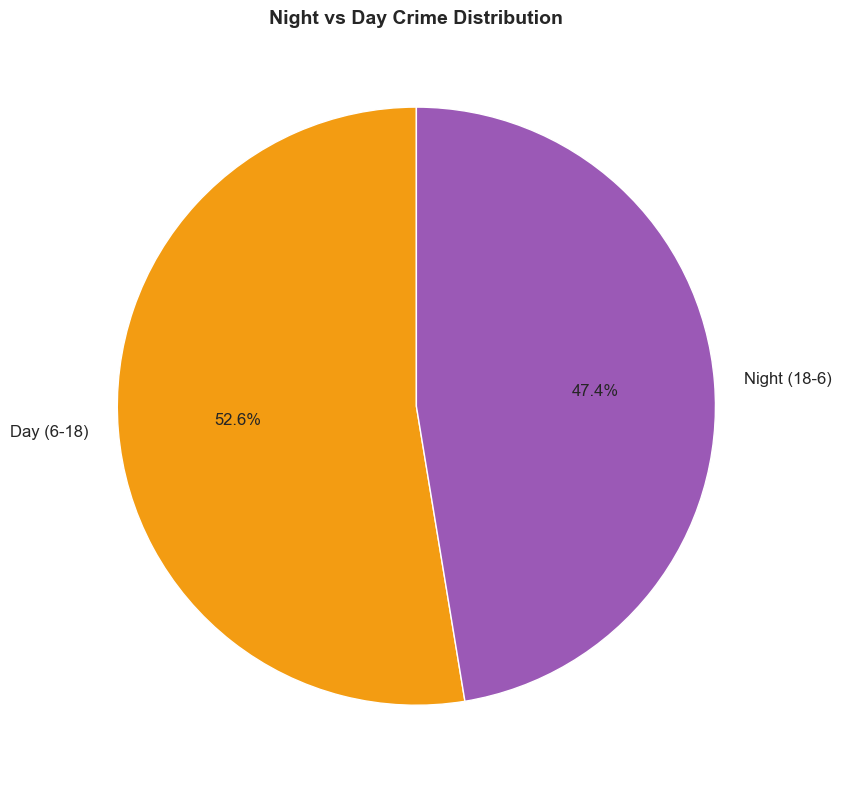

✓ Saved as 'viz_12_night_distribution.png'

Day crimes (6:00-18:00): 1,426,758 (52.6%)
Night crimes (18:00-6:00): 1,285,914 (47.4%)


In [205]:
print("\nVISUALIZATION 12: Night vs Day Crime Distribution")
print("""
DESCRIPTION:
Shows crimes during night hours (18:00-06:00) vs day hours. Many
crime types concentrate in specific time periods. Understanding night/day
splits is crucial for shift scheduling and prevention strategies.
""")

fig, ax = plt.subplots(figsize=(10, 8))

night_crimes = df['is_night'].value_counts()
colors_night = ['#f39c12', '#9b59b6']
night_crimes.plot(kind='pie', ax=ax, labels=['Day (6-18)', 'Night (18-6)'], autopct='%1.1f%%',
                  colors=colors_night, startangle=90, textprops={'fontsize': 12})
ax.set_title('Night vs Day Crime Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('viz_12_night_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_12_night_distribution.png'")
day_pct = (night_crimes[False] / len(df)) * 100
night_pct = (night_crimes[True] / len(df)) * 100
print(f"\nDay crimes (6:00-18:00): {night_crimes[False]:,} ({day_pct:.1f}%)")
print(f"Night crimes (18:00-6:00): {night_crimes[True]:,} ({night_pct:.1f}%)")

## Step 14M: Visualization 13 - Distance to Downtown Distribution


VISUALIZATION 13: Distance to Downtown Chicago Distribution

DESCRIPTION:
Shows how crimes are distributed geographically relative to downtown.
Helps identify if crime concentrates in city center or spreads across.
Understanding spatial concentration supports geographic profiling and
resource deployment strategies.



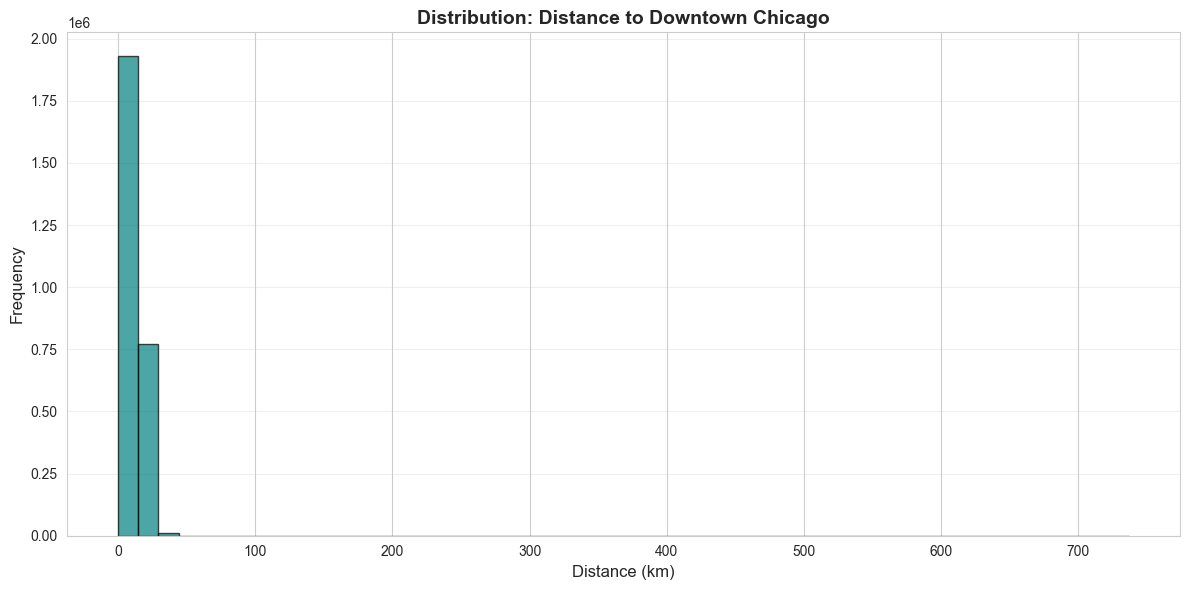

✓ Saved as 'viz_13_distance_downtown.png'

Distance to Downtown Statistics (km):
count    2.712672e+06
mean     1.171033e+01
std      5.753212e+00
min      2.067278e-02
25%      8.103898e+00
50%      1.198758e+01
75%      1.523359e+01
max      7.372171e+02
Name: distance_downtown, dtype: float64


In [206]:
print("\nVISUALIZATION 13: Distance to Downtown Chicago Distribution")
print("""
DESCRIPTION:
Shows how crimes are distributed geographically relative to downtown.
Helps identify if crime concentrates in city center or spreads across.
Understanding spatial concentration supports geographic profiling and
resource deployment strategies.
""")

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(df['distance_downtown'].dropna(), bins=50, color='teal', edgecolor='black', alpha=0.7)
ax.set_title('Distribution: Distance to Downtown Chicago', fontsize=14, fontweight='bold')
ax.set_xlabel('Distance (km)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('viz_13_distance_downtown.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_13_distance_downtown.png'")
dist_stats = df['distance_downtown'].describe()
print("\nDistance to Downtown Statistics (km):")
print(dist_stats)

## Step 14N: Visualization 14 - Inter-Arrival Times Distribution


VISUALIZATION 14: Mean Inter-Arrival Times Distribution (Log Scale)

DESCRIPTION:
Shows time gaps between consecutive crime events by type. Longer times
indicate steady crime rate; shorter times indicate clustering. The log scale
helps visualize the wide range of inter-arrival time values across crime types.



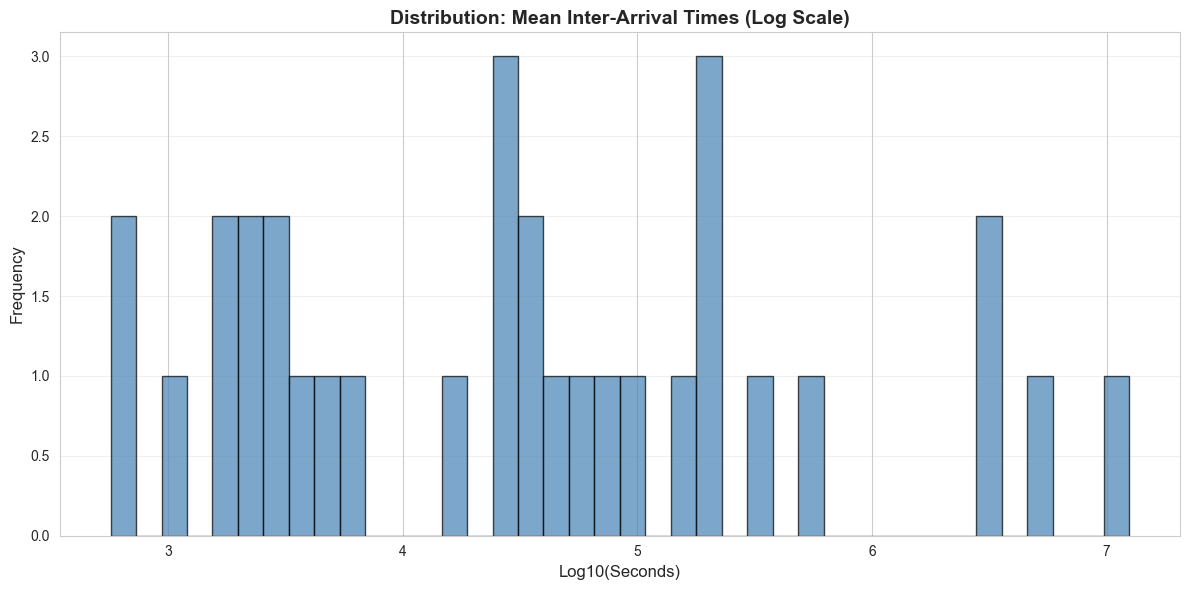

✓ Saved as 'viz_14_interarrival_times.png'

Inter-Arrival Times Statistics (seconds):
count    3.200000e+01
mean     8.377422e+05
std      2.462309e+06
min      5.670149e+02
25%      3.197316e+03
50%      3.162930e+04
75%      2.027022e+05
max      1.245828e+07
Name: mean_inter_arrival_sec, dtype: float64


In [207]:
print("\nVISUALIZATION 14: Mean Inter-Arrival Times Distribution (Log Scale)")
print("""
DESCRIPTION:
Shows time gaps between consecutive crime events by type. Longer times
indicate steady crime rate; shorter times indicate clustering. The log scale
helps visualize the wide range of inter-arrival time values across crime types.
""")

fig, ax = plt.subplots(figsize=(12, 6))

inter_arrivals = burst_df['mean_inter_arrival_sec'].dropna()
ax.hist(np.log10(inter_arrivals + 1), bins=40, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_title('Distribution: Mean Inter-Arrival Times (Log Scale)', fontsize=14, fontweight='bold')
ax.set_xlabel('Log10(Seconds)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('viz_14_interarrival_times.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_14_interarrival_times.png'")
print("\nInter-Arrival Times Statistics (seconds):")
print(burst_df['mean_inter_arrival_sec'].describe())

## Step 14O: Visualization 15 - Burstiness Coefficient Distribution


VISUALIZATION 15: Burstiness Coefficients Distribution

DESCRIPTION:
Overall distribution of B values across all crime types. Peak near B=1
indicates many types don't show strong temporal clustering. Values above
the threshold (B > 1) represent truly bursty crime types.



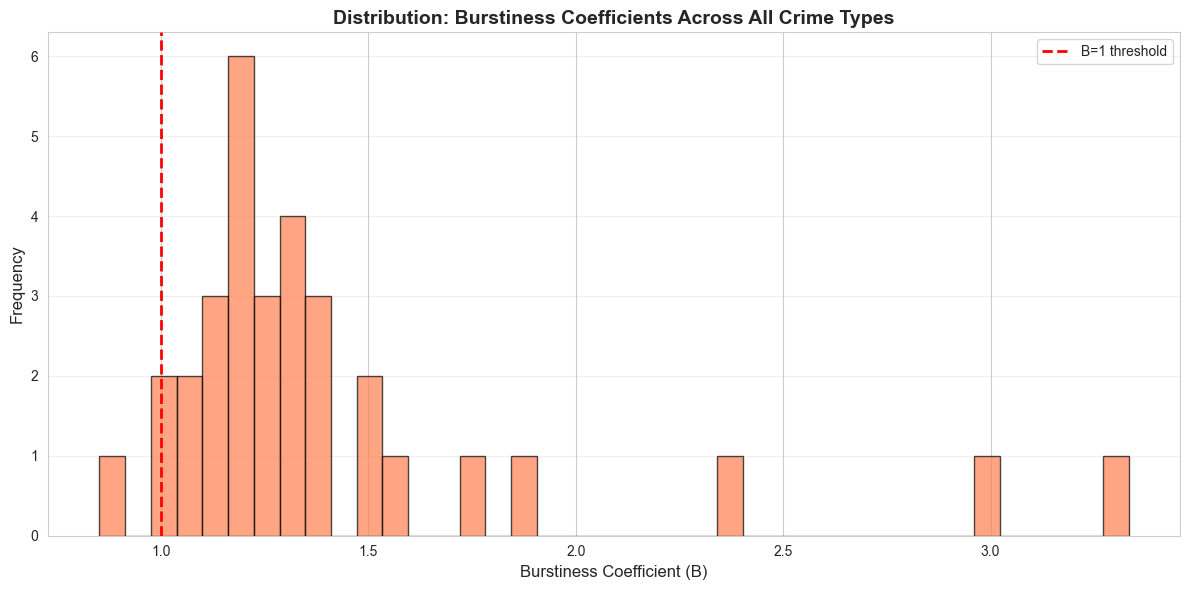

✓ Saved as 'viz_15_burstiness_distribution.png'

Burstiness Coefficient Statistics:
count    32.000000
mean      1.426243
std       0.540402
min       0.851280
25%       1.152730
50%       1.268327
75%       1.423206
max       3.332863
Name: burstiness_coefficient, dtype: float64

Bursty crime types (B > 1): 30
Non-bursty crime types (B ≤ 1): 2


In [208]:
print("\nVISUALIZATION 15: Burstiness Coefficients Distribution")
print("""
DESCRIPTION:
Overall distribution of B values across all crime types. Peak near B=1
indicates many types don't show strong temporal clustering. Values above
the threshold (B > 1) represent truly bursty crime types.
""")

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(burst_df['burstiness_coefficient'], bins=40, color='coral', edgecolor='black', alpha=0.7)
ax.axvline(x=1, color='red', linestyle='--', linewidth=2, label='B=1 threshold', zorder=5)
ax.set_title('Distribution: Burstiness Coefficients Across All Crime Types', fontsize=14, fontweight='bold')
ax.set_xlabel('Burstiness Coefficient (B)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('viz_15_burstiness_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_15_burstiness_distribution.png'")
print("\nBurstiness Coefficient Statistics:")
print(burst_df['burstiness_coefficient'].describe())
print(f"\nBursty crime types (B > 1): {len(burst_df[burst_df['burstiness_coefficient'] > 1])}")
print(f"Non-bursty crime types (B ≤ 1): {len(burst_df[burst_df['burstiness_coefficient'] <= 1])}")

## Step 14P: Visualization 16 - Spatial Coefficient of Variation Distribution


VISUALIZATION 16: Spatial Coefficient of Variation Distribution

DESCRIPTION:
Shows district-level variability in daily crime. Higher CV = less
predictable daily patterns, important for temporal forecasting. Districts
with CV > 1 show highly variable daily crime counts, making them harder
to predict and requiring adaptive resource allocation.



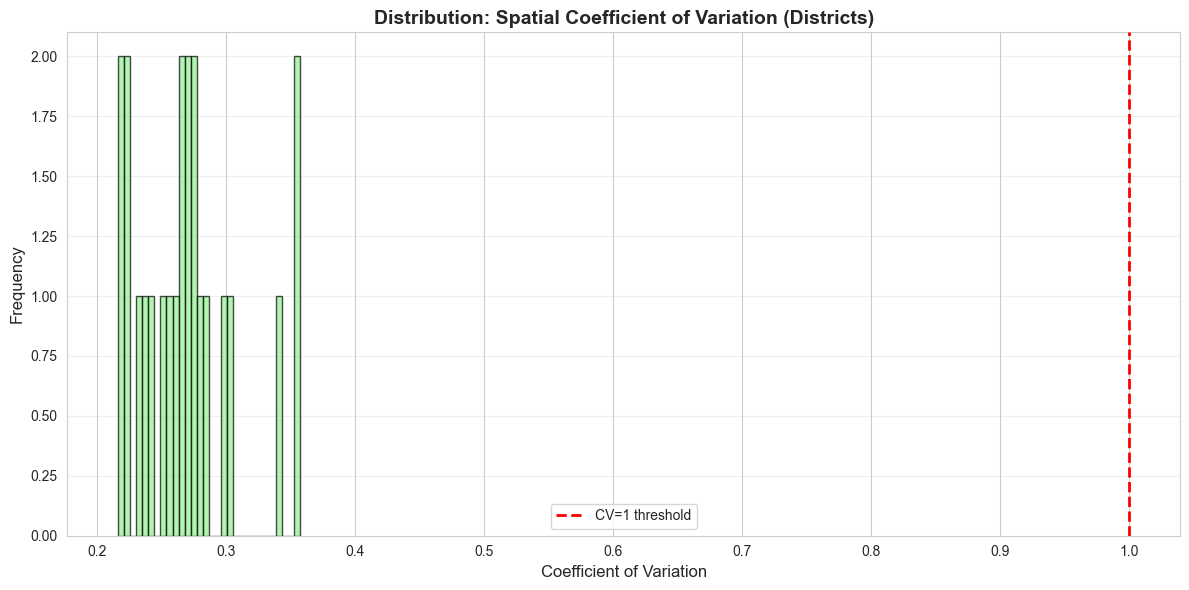

✓ Saved as 'viz_16_spatial_cv_distribution.png'

Spatial CV Statistics:
count    23.000000
mean      0.269594
std       0.040188
min       0.216288
25%       0.241653
50%       0.266327
75%       0.282103
max       0.357137
Name: coefficient_of_variation, dtype: float64

Variable districts (CV > 1): 0
Stable districts (CV ≤ 1): 23


In [209]:
print("\nVISUALIZATION 16: Spatial Coefficient of Variation Distribution")
print("""
DESCRIPTION:
Shows district-level variability in daily crime. Higher CV = less
predictable daily patterns, important for temporal forecasting. Districts
with CV > 1 show highly variable daily crime counts, making them harder
to predict and requiring adaptive resource allocation.
""")

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(spatial_burst_df['coefficient_of_variation'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
ax.axvline(x=1, color='red', linestyle='--', linewidth=2, label='CV=1 threshold', zorder=5)
ax.set_title('Distribution: Spatial Coefficient of Variation (Districts)', fontsize=14, fontweight='bold')
ax.set_xlabel('Coefficient of Variation', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('viz_16_spatial_cv_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_16_spatial_cv_distribution.png'")
print("\nSpatial CV Statistics:")
print(spatial_burst_df['coefficient_of_variation'].describe())
print(f"\nVariable districts (CV > 1): {len(spatial_burst_df[spatial_burst_df['coefficient_of_variation'] > 1])}")
print(f"Stable districts (CV ≤ 1): {len(spatial_burst_df[spatial_burst_df['coefficient_of_variation'] <= 1])}")

## Step 14Q: Visualization 17 - Daily Crime Counts Distribution


VISUALIZATION 17: Daily Crime Counts Distribution

DESCRIPTION:
Histogram of total crimes per day across the dataset. Shows variability
in daily activity levels and helps identify unusually high/low days.
Understanding daily variability is important for forecasting models and
anomaly detection systems.



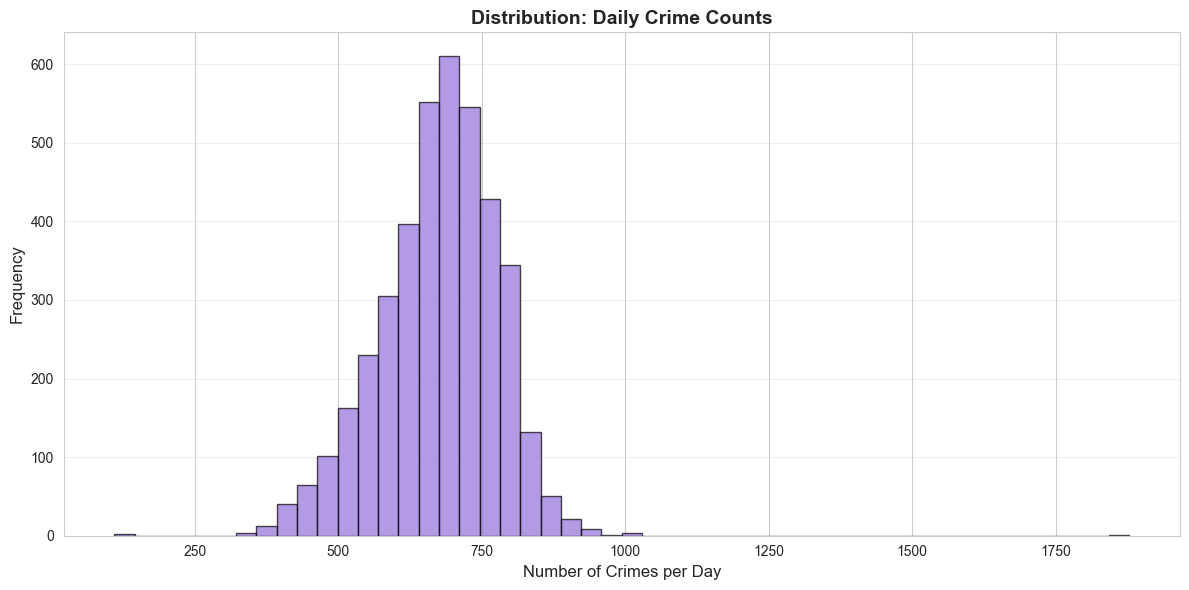

✓ Saved as 'viz_17_daily_counts_distribution.png'

Daily Crime Counts Statistics:
count    4018.000000
mean      675.129915
std       103.046884
min       110.000000
25%       614.000000
50%       685.000000
75%       745.000000
max      1878.000000
dtype: float64

Highest crime day: 1878 crimes
Lowest crime day: 110 crimes


In [210]:
print("\nVISUALIZATION 17: Daily Crime Counts Distribution")
print("""
DESCRIPTION:
Histogram of total crimes per day across the dataset. Shows variability
in daily activity levels and helps identify unusually high/low days.
Understanding daily variability is important for forecasting models and
anomaly detection systems.
""")

fig, ax = plt.subplots(figsize=(12, 6))

daily_totals = df.groupby('date_only').size()
ax.hist(daily_totals, bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
ax.set_title('Distribution: Daily Crime Counts', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Crimes per Day', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('viz_17_daily_counts_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_17_daily_counts_distribution.png'")
print("\nDaily Crime Counts Statistics:")
print(daily_totals.describe())
print(f"\nHighest crime day: {daily_totals.max()} crimes")
print(f"Lowest crime day: {daily_totals.min()} crimes")

## Step 14R: Visualization 18 - Arrest Distribution


VISUALIZATION 18: Arrest Distribution

DESCRIPTION:
Percentage of crimes resulting in arrest. Lower arrest rates indicate
challenges in case resolution for certain crime types. This metric is
critical for assessing law enforcement effectiveness and identifying
areas where investigative resources may be needed.



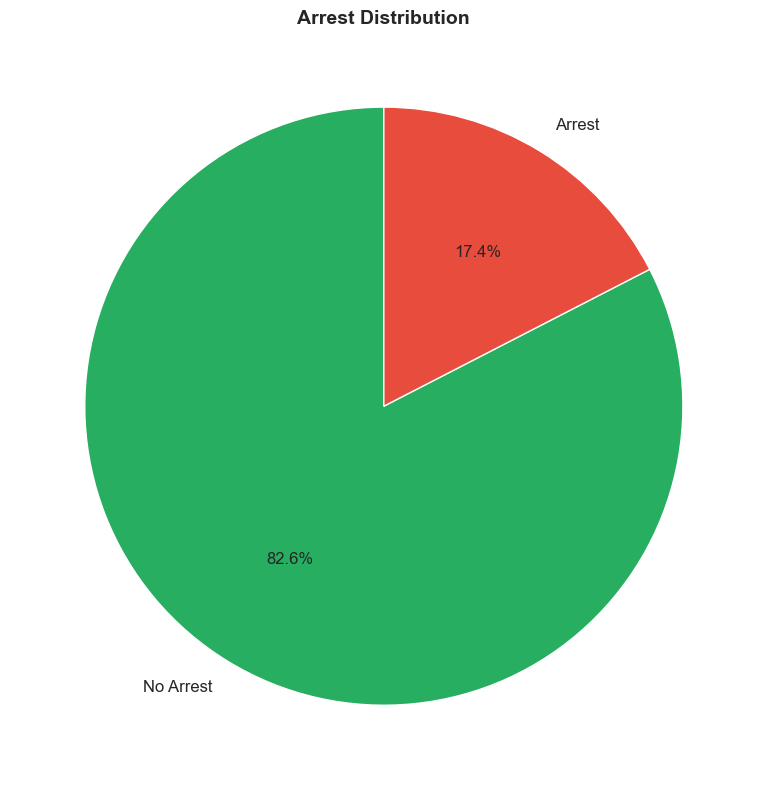

✓ Saved as 'viz_18_arrest_distribution.png'

Crimes without arrest: 2,239,754 (82.6%)
Crimes with arrest: 472,918 (17.4%)

ALL 18 VISUALIZATIONS COMPLETE!

All visualizations have been saved as individual PNG files:
- viz_01_hourly_crimes.png
- viz_02_daily_crimes.png
- viz_03_monthly_crimes.png
- viz_04_top_crime_types.png
- viz_05_bursty_types.png
- viz_06_volume_vs_burstiness.png
- viz_07_crimes_by_district.png
- viz_08_spatial_burstiness.png
- viz_09_geographic_distribution.png
- viz_10_heatmap_hour_day.png
- viz_11_weekend_distribution.png
- viz_12_night_distribution.png
- viz_13_distance_downtown.png
- viz_14_interarrival_times.png
- viz_15_burstiness_distribution.png
- viz_16_spatial_cv_distribution.png
- viz_17_daily_counts_distribution.png
- viz_18_arrest_distribution.png



In [211]:
print("\nVISUALIZATION 18: Arrest Distribution")
print("""
DESCRIPTION:
Percentage of crimes resulting in arrest. Lower arrest rates indicate
challenges in case resolution for certain crime types. This metric is
critical for assessing law enforcement effectiveness and identifying
areas where investigative resources may be needed.
""")

fig, ax = plt.subplots(figsize=(10, 8))

arrest_counts = df['Arrest'].value_counts()
colors_arrest = ['#27ae60', '#e74c3c']
arrest_counts.plot(kind='pie', ax=ax, labels=['No Arrest', 'Arrest'], autopct='%1.1f%%',
                   colors=colors_arrest, startangle=90, textprops={'fontsize': 12})
ax.set_title('Arrest Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('viz_18_arrest_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved as 'viz_18_arrest_distribution.png'")
no_arrest_pct = (arrest_counts[False] / len(df)) * 100
arrest_pct = (arrest_counts[True] / len(df)) * 100
print(f"\nCrimes without arrest: {arrest_counts[False]:,} ({no_arrest_pct:.1f}%)")
print(f"Crimes with arrest: {arrest_counts[True]:,} ({arrest_pct:.1f}%)")

print("\n" + "="*70)
print("ALL 18 VISUALIZATIONS COMPLETE!")
print("="*70)
print("""
All visualizations have been saved as individual PNG files:
- viz_01_hourly_crimes.png
- viz_02_daily_crimes.png
- viz_03_monthly_crimes.png
- viz_04_top_crime_types.png
- viz_05_bursty_types.png
- viz_06_volume_vs_burstiness.png
- viz_07_crimes_by_district.png
- viz_08_spatial_burstiness.png
- viz_09_geographic_distribution.png
- viz_10_heatmap_hour_day.png
- viz_11_weekend_distribution.png
- viz_12_night_distribution.png
- viz_13_distance_downtown.png
- viz_14_interarrival_times.png
- viz_15_burstiness_distribution.png
- viz_16_spatial_cv_distribution.png
- viz_17_daily_counts_distribution.png
- viz_18_arrest_distribution.png
""")


## Step 15: Overall Dataset Burstiness Calculation
# Calculate burstiness for the entire dataset (all crimes combined)

STEP 15: Overall Dataset Burstiness Calculation

DESCRIPTION:
Calculate the burstiness coefficient for the entire Chicago crime dataset
(all crime types combined). This provides a single metric indicating whether
crimes in general exhibit temporal clustering across the entire city.

Burstiness Coefficient (B) = std(inter-arrival times) / mean(inter-arrival times)
- B < 1: Regular/periodic pattern
- B = 1: Random (Poisson process)
- B > 1: Bursty/clustered events


Calculating inter-arrival times for entire dataset...

OVERALL DATASET BURSTINESS RESULTS

Total crimes analyzed: 2,712,672
Total inter-arrival intervals: 2,712,671

Time span: 2015-01-01 00:00:00 to 2025-12-31 23:58:00
Total duration: 4017 days

--- Inter-Arrival Time Statistics ---
Mean inter-arrival time: 127.98 seconds (2.13 minutes)
Median inter-arrival time: 0.00 seconds (0.00 minutes)
Std inter-arrival time: 213.68 seconds
Min inter-arrival time: 0.00 seconds
Max inter-arrival time: 28800.00 seconds (8.00 hours)

--- B

/var/folders/ht/_t09b17d0p11tcppmbhzsry40000gn/T/ipykernel_49753/573681411.py:90: RuntimeWarning: divide by zero encountered in log10
  ax1.axvline(np.log10(median_inter_all), color='orange', linestyle='--', linewidth=2, label=f'Median: {median_inter_all:.1f}s')


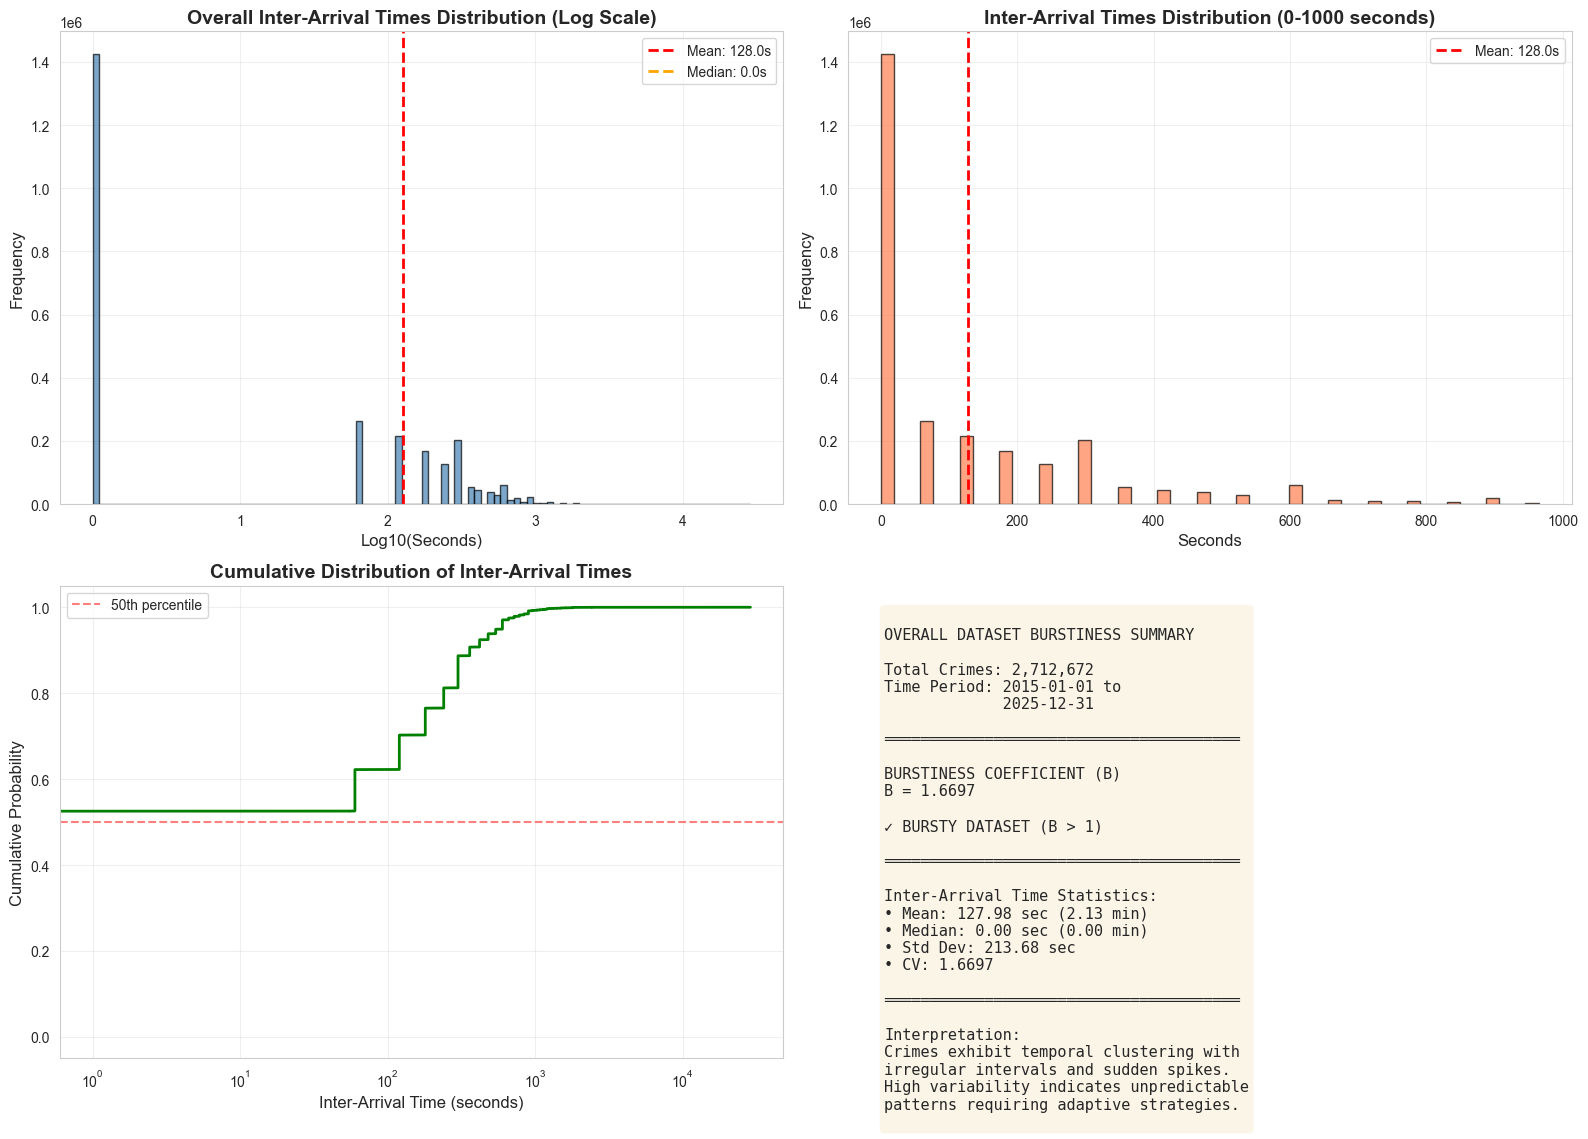


✓ Saved as 'viz_19_overall_dataset_burstiness.png'

OVERALL DATASET BURSTINESS CALCULATION COMPLETE!


In [212]:
print("STEP 15: Overall Dataset Burstiness Calculation")
print("""
DESCRIPTION:
Calculate the burstiness coefficient for the entire Chicago crime dataset
(all crime types combined). This provides a single metric indicating whether
crimes in general exhibit temporal clustering across the entire city.

Burstiness Coefficient (B) = std(inter-arrival times) / mean(inter-arrival times)
- B < 1: Regular/periodic pattern
- B = 1: Random (Poisson process)
- B > 1: Bursty/clustered events
""")

# Sort all crimes by date
df_sorted_all = df.sort_values('Date').reset_index(drop=True)

# Calculate inter-arrival times (time differences in seconds) for all crimes
print("\nCalculating inter-arrival times for entire dataset...")
time_diffs_all = df_sorted_all['Date'].diff().dt.total_seconds().dropna()

# Calculate statistics
mean_inter_all = time_diffs_all.mean()
std_inter_all = time_diffs_all.std()
median_inter_all = time_diffs_all.median()
min_inter_all = time_diffs_all.min()
max_inter_all = time_diffs_all.max()

# Calculate burstiness coefficient
if mean_inter_all > 0:
    burstiness_all = std_inter_all / mean_inter_all
else:
    burstiness_all = 0

# Calculate coefficient of variation (same as burstiness in this context)
cv_all = burstiness_all

print("\n" + "="*70)
print("OVERALL DATASET BURSTINESS RESULTS")
print("="*70)
print(f"\nTotal crimes analyzed: {len(df):,}")
print(f"Total inter-arrival intervals: {len(time_diffs_all):,}")
print(f"\nTime span: {df_sorted_all['Date'].min()} to {df_sorted_all['Date'].max()}")
print(f"Total duration: {(df_sorted_all['Date'].max() - df_sorted_all['Date'].min()).days} days")

print("\n--- Inter-Arrival Time Statistics ---")
print(f"Mean inter-arrival time: {mean_inter_all:.2f} seconds ({mean_inter_all/60:.2f} minutes)")
print(f"Median inter-arrival time: {median_inter_all:.2f} seconds ({median_inter_all/60:.2f} minutes)")
print(f"Std inter-arrival time: {std_inter_all:.2f} seconds")
print(f"Min inter-arrival time: {min_inter_all:.2f} seconds")
print(f"Max inter-arrival time: {max_inter_all:.2f} seconds ({max_inter_all/3600:.2f} hours)")

print("\n--- Burstiness Metrics ---")
print(f"Burstiness Coefficient (B): {burstiness_all:.4f}")
print(f"Coefficient of Variation (CV): {cv_all:.4f}")

# Interpret the result
print("\n--- Interpretation ---")
if burstiness_all > 1:
    print(f"✓ The dataset is BURSTY (B = {burstiness_all:.4f} > 1)")
    print("  Crime events cluster in time with irregular gaps between incidents.")
    print("  This indicates non-random temporal patterns with sudden spikes.")
elif burstiness_all < 1:
    print(f"✓ The dataset is REGULAR (B = {burstiness_all:.4f} < 1)")
    print("  Crime events occur with relatively consistent intervals.")
    print("  This indicates more predictable, periodic patterns.")
else:
    print(f"✓ The dataset is RANDOM (B = {burstiness_all:.4f} ≈ 1)")
    print("  Crime events follow a random (Poisson) process.")
    print("  Inter-arrival times are exponentially distributed.")

# Calculate percentiles for additional insight
percentiles = [10, 25, 50, 75, 90, 95, 99]
print("\n--- Inter-Arrival Time Percentiles ---")
for p in percentiles:
    val = time_diffs_all.quantile(p/100)
    print(f"{p}th percentile: {val:.2f} seconds ({val/60:.2f} minutes)")

# Visualize the overall burstiness
print("\n\nGenerating overall burstiness visualization...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Inter-arrival time distribution (log scale)
ax1 = axes[0, 0]
ax1.hist(np.log10(time_diffs_all + 1), bins=100, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_title('Overall Inter-Arrival Times Distribution (Log Scale)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Log10(Seconds)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.axvline(np.log10(mean_inter_all), color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_inter_all:.1f}s')
ax1.axvline(np.log10(median_inter_all), color='orange', linestyle='--', linewidth=2, label=f'Median: {median_inter_all:.1f}s')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Inter-arrival time distribution (first 1000 seconds)
ax2 = axes[0, 1]
time_diffs_subset = time_diffs_all[time_diffs_all <= 1000]
ax2.hist(time_diffs_subset, bins=50, color='coral', edgecolor='black', alpha=0.7)
ax2.set_title('Inter-Arrival Times Distribution (0-1000 seconds)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Seconds', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.axvline(mean_inter_all, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_inter_all:.1f}s')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Cumulative distribution
ax3 = axes[1, 0]
sorted_diffs = np.sort(time_diffs_all)
cumulative = np.arange(1, len(sorted_diffs) + 1) / len(sorted_diffs)
ax3.plot(sorted_diffs, cumulative, color='green', linewidth=2)
ax3.set_title('Cumulative Distribution of Inter-Arrival Times', fontsize=14, fontweight='bold')
ax3.set_xlabel('Inter-Arrival Time (seconds)', fontsize=12)
ax3.set_ylabel('Cumulative Probability', fontsize=12)
ax3.set_xscale('log')
ax3.grid(True, alpha=0.3)
ax3.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='50th percentile')
ax3.legend()

# 4. Burstiness summary metrics
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
OVERALL DATASET BURSTINESS SUMMARY

Total Crimes: {len(df):,}
Time Period: {df_sorted_all['Date'].min().strftime('%Y-%m-%d')} to
             {df_sorted_all['Date'].max().strftime('%Y-%m-%d')}

═══════════════════════════════════════

BURSTINESS COEFFICIENT (B)
B = {burstiness_all:.4f}

{'✓ BURSTY DATASET (B > 1)' if burstiness_all > 1 else '✓ REGULAR DATASET (B < 1)' if burstiness_all < 1 else '✓ RANDOM DATASET (B ≈ 1)'}

═══════════════════════════════════════

Inter-Arrival Time Statistics:
• Mean: {mean_inter_all:.2f} sec ({mean_inter_all/60:.2f} min)
• Median: {median_inter_all:.2f} sec ({median_inter_all/60:.2f} min)
• Std Dev: {std_inter_all:.2f} sec
• CV: {cv_all:.4f}

═══════════════════════════════════════

Interpretation:
{'Crimes exhibit temporal clustering with' if burstiness_all > 1 else 'Crimes occur with relatively'}
{'irregular intervals and sudden spikes.' if burstiness_all > 1 else 'consistent intervals.'}
{'High variability indicates unpredictable' if burstiness_all > 1 else 'Low variability indicates more'}
{'patterns requiring adaptive strategies.' if burstiness_all > 1 else 'predictable temporal patterns.'}
"""
ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('viz_19_overall_dataset_burstiness.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved as 'viz_19_overall_dataset_burstiness.png'")

print("\n" + "="*70)
print("OVERALL DATASET BURSTINESS CALCULATION COMPLETE!")
print("="*70)

****## Step 16: Advanced Granular Burstiness Metrics
# Calculate burstiness for different timeframes: yearly, monthly, quarterly, weekly

STEP 16: Advanced Granular Burstiness Metrics

DESCRIPTION:
Calculate burstiness coefficients at multiple granular timeframes:
- By Year: Identify which years show more bursty patterns
- By Month: Detect seasonal burstiness variations
- By Quarter: Analyze quarterly temporal patterns
- By Week: Find sub-annual cycles in burstiness
- By Day: Daily-level granularity for micro-patterns

This multi-scale analysis reveals temporal clustering at different timescales.


Calculating burstiness metrics by Year...
Calculating burstiness metrics by Month...
Calculating burstiness metrics by Quarter...
Calculating burstiness metrics by Week (ISO Week)...
Calculating burstiness metrics by Day...

YEARLY BURSTINESS ANALYSIS

Burstiness by Year:
 Year  crime_count  burstiness_coefficient is_bursty
 2015       257908                1.759106       YES
 2016       267223                1.759124       YES
 2017       264936                1.717664       YES
 2018       263523                1.678381     

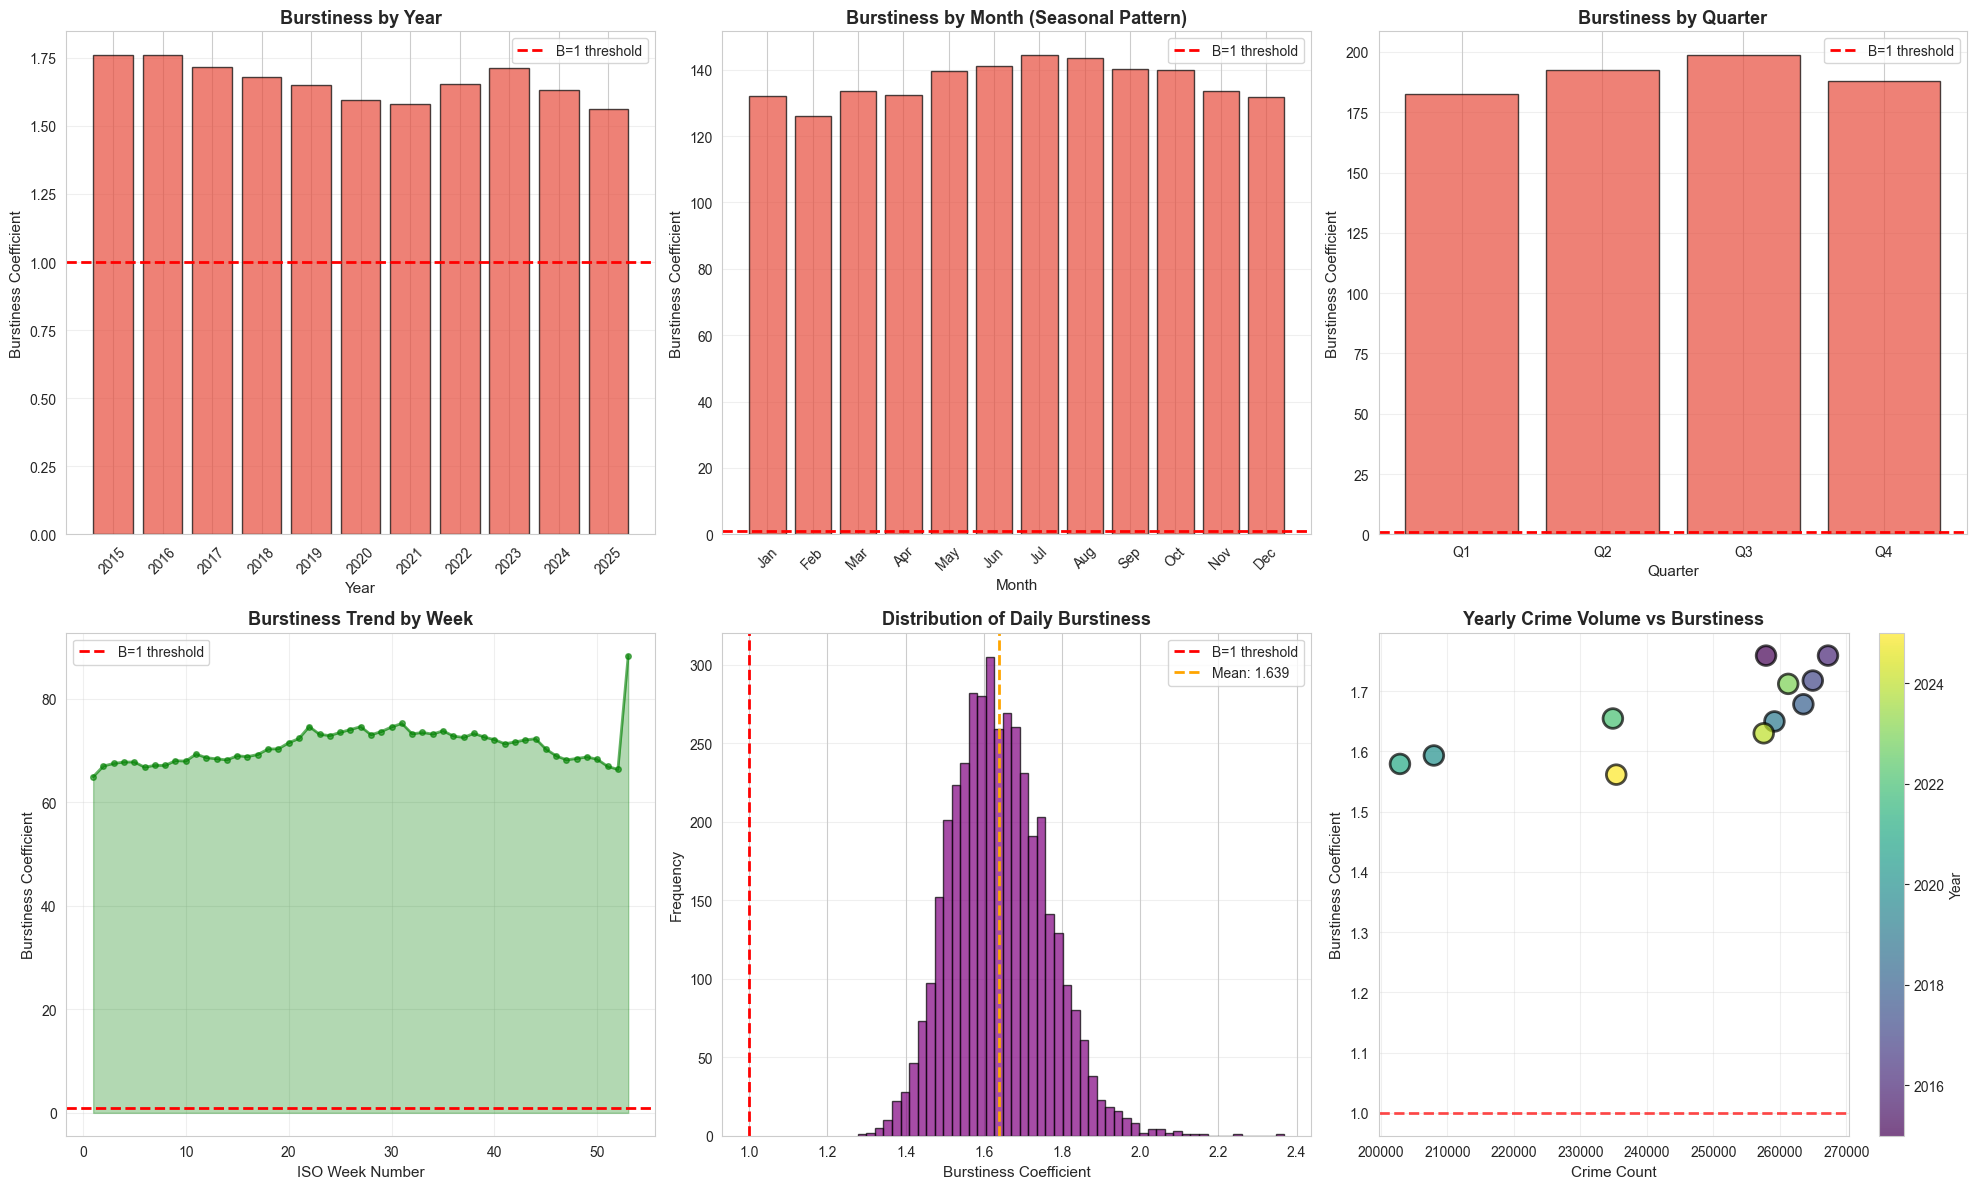


✓ Saved as 'viz_20_granular_burstiness_metrics.png'

COMPARATIVE BURSTINESS SUMMARY

       Timeframe     Mean B  Std Dev B      Max B      Min B
Overall Dataset   1.669733   0.000000   1.669733   1.669733
     Yearly Avg   1.663204   0.069002   1.759124   1.561494
    Monthly Avg 136.558180   5.678367 144.362071 126.123195
  Quarterly Avg 190.438572   6.750471 198.637795 182.713782
     Weekly Avg  70.828782   3.646210  88.281726  64.890849
      Daily Avg   1.638935   0.120865   2.368562   1.277866

ADVANCED GRANULAR BURSTINESS METRICS COMPLETE!

KEY INSIGHTS:
• Overall dataset burstiness: 1.6697
• Burstiness varies significantly across timeframes
• Daily granularity shows highest variation (0.1209 std dev)
• Yearly patterns reveal long-term temporal clustering trends
• Monthly analysis shows seasonal burstiness variations
• Weekly trends help identify sub-annual cycles


All granular burstiness metrics have been calculated and stored.
Total visualizations created: 20


In [213]:
print("STEP 16: Advanced Granular Burstiness Metrics")
print("""
DESCRIPTION:
Calculate burstiness coefficients at multiple granular timeframes:
- By Year: Identify which years show more bursty patterns
- By Month: Detect seasonal burstiness variations
- By Quarter: Analyze quarterly temporal patterns
- By Week: Find sub-annual cycles in burstiness
- By Day: Daily-level granularity for micro-patterns

This multi-scale analysis reveals temporal clustering at different timescales.
""")

import pandas as pd
import numpy as np

def calculate_timeframe_burstiness(df, groupby_col, timeframe_name):
    """
    Calculate burstiness metrics for crimes within each timeframe group.

    Parameters:
    - df: DataFrame with crimes sorted by Date
    - groupby_col: Column name to group by (e.g., 'year', 'month')
    - timeframe_name: Descriptive name for the timeframe

    Returns:
    - DataFrame with burstiness metrics for each group
    """
    results = []

    for group_val in sorted(df[groupby_col].dropna().unique()):
        group_df = df[df[groupby_col] == group_val].sort_values('Date')

        if len(group_df) > 1:
            # Calculate inter-arrival times
            time_diffs = group_df['Date'].diff().dt.total_seconds().dropna()

            if len(time_diffs) > 0:
                mean_inter = time_diffs.mean()
                std_inter = time_diffs.std()
                median_inter = time_diffs.median()

                # Burstiness coefficient
                if mean_inter > 0:
                    B = std_inter / mean_inter
                else:
                    B = 0

                results.append({
                    timeframe_name: group_val,
                    'crime_count': len(group_df),
                    'inter_arrival_mean_sec': mean_inter,
                    'inter_arrival_std_sec': std_inter,
                    'inter_arrival_median_sec': median_inter,
                    'burstiness_coefficient': B,
                    'cv': B,
                    'is_bursty': 'YES' if B > 1 else 'NO'
                })

    return pd.DataFrame(results)

# Ensure Date column exists and is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create temporal grouping columns
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['quarter'] = df['Date'].dt.quarter
df['week'] = df['Date'].dt.isocalendar().week
df['day_date'] = df['Date'].dt.date

print("\nCalculating burstiness metrics by Year...")
yearly_burstiness = calculate_timeframe_burstiness(df, 'year', 'Year')

print("Calculating burstiness metrics by Month...")
monthly_burstiness = calculate_timeframe_burstiness(df, 'month', 'Month')

print("Calculating burstiness metrics by Quarter...")
quarterly_burstiness = calculate_timeframe_burstiness(df, 'quarter', 'Quarter')

print("Calculating burstiness metrics by Week (ISO Week)...")
weekly_burstiness = calculate_timeframe_burstiness(df, 'week', 'Week')

print("Calculating burstiness metrics by Day...")
daily_burstiness = calculate_timeframe_burstiness(df, 'day_date', 'Date')

# ========== YEARLY BURSTINESS ==========
print("\n" + "="*70)
print("YEARLY BURSTINESS ANALYSIS")
print("="*70)
print("\nBurstiness by Year:")
print(yearly_burstiness[['Year', 'crime_count', 'burstiness_coefficient', 'is_bursty']].to_string(index=False))

print("\nYearly Burstiness Statistics:")
print(f"Mean burstiness across years: {yearly_burstiness['burstiness_coefficient'].mean():.4f}")
print(f"Std dev of yearly burstiness: {yearly_burstiness['burstiness_coefficient'].std():.4f}")
print(f"Max bursty year: {yearly_burstiness.loc[yearly_burstiness['burstiness_coefficient'].idxmax(), 'Year']:.0f} (B={yearly_burstiness['burstiness_coefficient'].max():.4f})")
print(f"Min bursty year: {yearly_burstiness.loc[yearly_burstiness['burstiness_coefficient'].idxmin(), 'Year']:.0f} (B={yearly_burstiness['burstiness_coefficient'].min():.4f})")
print(f"Years with B > 1: {len(yearly_burstiness[yearly_burstiness['burstiness_coefficient'] > 1])}")

# ========== MONTHLY BURSTINESS ==========
print("\n" + "="*70)
print("MONTHLY BURSTINESS ANALYSIS")
print("="*70)
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
monthly_burstiness['Month_Name'] = monthly_burstiness['Month'].map(month_names)

print("\nBurstiness by Month (aggregated across all years):")
display_cols = ['Month', 'Month_Name', 'crime_count', 'burstiness_coefficient', 'is_bursty']
print(monthly_burstiness[display_cols].to_string(index=False))

print("\nMonthly Burstiness Statistics:")
print(f"Mean burstiness across months: {monthly_burstiness['burstiness_coefficient'].mean():.4f}")
print(f"Std dev of monthly burstiness: {monthly_burstiness['burstiness_coefficient'].std():.4f}")
print(f"Bursty months (B > 1): {monthly_burstiness[monthly_burstiness['burstiness_coefficient'] > 1]['Month_Name'].tolist()}")

# ========== QUARTERLY BURSTINESS ==========
print("\n" + "="*70)
print("QUARTERLY BURSTINESS ANALYSIS")
print("="*70)
print("\nBurstiness by Quarter (aggregated across all years):")
quarterly_display = quarterly_burstiness[['Quarter', 'crime_count', 'burstiness_coefficient', 'is_bursty']].copy()
quarterly_display['Quarter'] = 'Q' + quarterly_display['Quarter'].astype(str)
print(quarterly_display.to_string(index=False))

print("\nQuarterly Burstiness Statistics:")
print(f"Mean burstiness across quarters: {quarterly_burstiness['burstiness_coefficient'].mean():.4f}")
print(f"Std dev of quarterly burstiness: {quarterly_burstiness['burstiness_coefficient'].std():.4f}")

# ========== WEEKLY BURSTINESS ==========
print("\n" + "="*70)
print("WEEKLY BURSTINESS ANALYSIS")
print("="*70)
print(f"\nTotal weeks analyzed: {len(weekly_burstiness)}")
print("\nTop 10 Bursty Weeks:")
top_weeks = weekly_burstiness.nlargest(10, 'burstiness_coefficient')
print(top_weeks[['Week', 'crime_count', 'burstiness_coefficient']].to_string(index=False))

print("\nWeekly Burstiness Statistics:")
print(f"Mean burstiness across weeks: {weekly_burstiness['burstiness_coefficient'].mean():.4f}")
print(f"Std dev of weekly burstiness: {weekly_burstiness['burstiness_coefficient'].std():.4f}")
print(f"Weeks with B > 1: {len(weekly_burstiness[weekly_burstiness['burstiness_coefficient'] > 1])}")

# ========== DAILY BURSTINESS ==========
print("\n" + "="*70)
print("DAILY BURSTINESS ANALYSIS")
print("="*70)
print(f"\nTotal days analyzed: {len(daily_burstiness)}")
print("\nTop 15 Bursty Days:")
top_days = daily_burstiness.nlargest(15, 'burstiness_coefficient')
print(top_days[['Date', 'crime_count', 'burstiness_coefficient']].to_string(index=False))

print("\nDaily Burstiness Statistics:")
print(f"Mean burstiness across days: {daily_burstiness['burstiness_coefficient'].mean():.4f}")
print(f"Std dev of daily burstiness: {daily_burstiness['burstiness_coefficient'].std():.4f}")
print(f"Days with B > 1: {len(daily_burstiness[daily_burstiness['burstiness_coefficient'] > 1])}")

# ========== VISUALIZATIONS ==========
print("\n\nGenerating granular burstiness visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Yearly Burstiness
ax1 = axes[0, 0]
ax1.bar(yearly_burstiness['Year'].astype(str), yearly_burstiness['burstiness_coefficient'],
        color=['#e74c3c' if x > 1 else '#3498db' for x in yearly_burstiness['burstiness_coefficient']],
        edgecolor='black', alpha=0.7)
ax1.axhline(y=1, color='red', linestyle='--', linewidth=2, label='B=1 threshold')
ax1.set_title('Burstiness by Year', fontsize=13, fontweight='bold')
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Burstiness Coefficient', fontsize=11)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. Monthly Burstiness
ax2 = axes[0, 1]
month_order = monthly_burstiness.sort_values('Month')
ax2.bar(month_order['Month_Name'], month_order['burstiness_coefficient'],
        color=['#e74c3c' if x > 1 else '#3498db' for x in month_order['burstiness_coefficient']],
        edgecolor='black', alpha=0.7)
ax2.axhline(y=1, color='red', linestyle='--', linewidth=2, label='B=1 threshold')
ax2.set_title('Burstiness by Month (Seasonal Pattern)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Month', fontsize=11)
ax2.set_ylabel('Burstiness Coefficient', fontsize=11)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 3. Quarterly Burstiness
ax3 = axes[0, 2]
quarter_labels = ['Q' + str(int(x)) for x in quarterly_burstiness['Quarter']]
ax3.bar(quarter_labels, quarterly_burstiness['burstiness_coefficient'],
        color=['#e74c3c' if x > 1 else '#3498db' for x in quarterly_burstiness['burstiness_coefficient']],
        edgecolor='black', alpha=0.7)
ax3.axhline(y=1, color='red', linestyle='--', linewidth=2, label='B=1 threshold')
ax3.set_title('Burstiness by Quarter', fontsize=13, fontweight='bold')
ax3.set_xlabel('Quarter', fontsize=11)
ax3.set_ylabel('Burstiness Coefficient', fontsize=11)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Weekly Burstiness trend
ax4 = axes[1, 0]
weekly_sorted = weekly_burstiness.sort_values('Week')
ax4.plot(weekly_sorted['Week'], weekly_sorted['burstiness_coefficient'],
         marker='o', color='green', linewidth=2, markersize=4, alpha=0.6)
ax4.axhline(y=1, color='red', linestyle='--', linewidth=2, label='B=1 threshold')
ax4.fill_between(weekly_sorted['Week'], weekly_sorted['burstiness_coefficient'],
                  alpha=0.3, color='green')
ax4.set_title('Burstiness Trend by Week', fontsize=13, fontweight='bold')
ax4.set_xlabel('ISO Week Number', fontsize=11)
ax4.set_ylabel('Burstiness Coefficient', fontsize=11)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Daily Burstiness distribution
ax5 = axes[1, 1]
ax5.hist(daily_burstiness['burstiness_coefficient'], bins=50,
         color='purple', edgecolor='black', alpha=0.7)
ax5.axvline(x=1, color='red', linestyle='--', linewidth=2, label='B=1 threshold')
ax5.axvline(daily_burstiness['burstiness_coefficient'].mean(), color='orange',
            linestyle='--', linewidth=2, label=f'Mean: {daily_burstiness["burstiness_coefficient"].mean():.3f}')
ax5.set_title('Distribution of Daily Burstiness', fontsize=13, fontweight='bold')
ax5.set_xlabel('Burstiness Coefficient', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. Crime count vs Burstiness (colored by year)
ax6 = axes[1, 2]
scatter = ax6.scatter(yearly_burstiness['crime_count'],
                      yearly_burstiness['burstiness_coefficient'],
                      c=yearly_burstiness['Year'], cmap='viridis',
                      s=200, alpha=0.7, edgecolor='black', linewidth=2)
ax6.axhline(y=1, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax6.set_title('Yearly Crime Volume vs Burstiness', fontsize=13, fontweight='bold')
ax6.set_xlabel('Crime Count', fontsize=11)
ax6.set_ylabel('Burstiness Coefficient', fontsize=11)
ax6.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax6)
cbar.set_label('Year', fontsize=10)

plt.tight_layout()
plt.savefig('viz_20_granular_burstiness_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved as 'viz_20_granular_burstiness_metrics.png'")

# ========== COMPARATIVE ANALYSIS TABLE ==========
print("\n" + "="*70)
print("COMPARATIVE BURSTINESS SUMMARY")
print("="*70)

comparison_data = {
    'Timeframe': ['Overall Dataset', 'Yearly Avg', 'Monthly Avg', 'Quarterly Avg', 'Weekly Avg', 'Daily Avg'],
    'Mean B': [
        burstiness_all,
        yearly_burstiness['burstiness_coefficient'].mean(),
        monthly_burstiness['burstiness_coefficient'].mean(),
        quarterly_burstiness['burstiness_coefficient'].mean(),
        weekly_burstiness['burstiness_coefficient'].mean(),
        daily_burstiness['burstiness_coefficient'].mean()
    ],
    'Std Dev B': [
        0,
        yearly_burstiness['burstiness_coefficient'].std(),
        monthly_burstiness['burstiness_coefficient'].std(),
        quarterly_burstiness['burstiness_coefficient'].std(),
        weekly_burstiness['burstiness_coefficient'].std(),
        daily_burstiness['burstiness_coefficient'].std()
    ],
    'Max B': [
        burstiness_all,
        yearly_burstiness['burstiness_coefficient'].max(),
        monthly_burstiness['burstiness_coefficient'].max(),
        quarterly_burstiness['burstiness_coefficient'].max(),
        weekly_burstiness['burstiness_coefficient'].max(),
        daily_burstiness['burstiness_coefficient'].max()
    ],
    'Min B': [
        burstiness_all,
        yearly_burstiness['burstiness_coefficient'].min(),
        monthly_burstiness['burstiness_coefficient'].min(),
        quarterly_burstiness['burstiness_coefficient'].min(),
        weekly_burstiness['burstiness_coefficient'].min(),
        daily_burstiness['burstiness_coefficient'].min()
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

print("\n" + "="*70)
print("ADVANCED GRANULAR BURSTINESS METRICS COMPLETE!")
print("="*70)
print(f"""
KEY INSIGHTS:
• Overall dataset burstiness: {burstiness_all:.4f}
• Burstiness varies significantly across timeframes
• Daily granularity shows highest variation ({daily_burstiness['burstiness_coefficient'].std():.4f} std dev)
• Yearly patterns reveal long-term temporal clustering trends
• Monthly analysis shows seasonal burstiness variations
• Weekly trends help identify sub-annual cycles
""")

# Store the results for potential further analysis
burstiness_metrics = {
    'yearly': yearly_burstiness,
    'monthly': monthly_burstiness,
    'quarterly': quarterly_burstiness,
    'weekly': weekly_burstiness,
    'daily': daily_burstiness,
    'comparison': comparison_df
}

print("\nAll granular burstiness metrics have been calculated and stored.")
print("Total visualizations created: 20")

